In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import torch
from torchdiffeq import odeint
import pandas as pd
import pygot
import scvelo as scv
from tqdm import tqdm
import seaborn as sns
use_cuda = torch.cuda.is_available()
%matplotlib inline
device = torch.device("cuda" if use_cuda else "cpu")

In [2]:
plt.rcParams['font.sans-serif'] = ['Arial']

## Helper Function

In [3]:
import seaborn as sns
import scvelo as scv
def extract_diff_genes(adata, group1, filtered=True):


    
    if filtered:
        result = adata.uns['rank_genes_groups_filtered']
    else:
        result = adata.uns['rank_genes_groups']
    names = result['names'][group1]  
    pvals = result['pvals'][group1]  
    logfoldchanges = result['logfoldchanges'][group1]  
    scores = result['scores'][group1]
    

    diff_genes_df = pd.DataFrame({
        'names': names,
        'pvals': pvals,
        'logfoldchanges': logfoldchanges,
        'scores':scores
    })
    diff_genes_df = diff_genes_df.dropna(subset=['names'])
    return diff_genes_df

In [4]:
# This function is based on scVelo heatmap plot function
import numpy as np
import pandas as pd
from scipy.sparse import issparse

from scvelo import logging as logg
from scvelo.plotting.utils import (
    interpret_colorkey,
    is_categorical,
    savefig_or_show,
    set_colors_for_categorical_obs,
    strings_to_categoricals,
    to_list,
)


def bifurcation_heatmap(
    adata,
    
    var_names,
    bifurcate_key,
    b_pool,
    sort_by_bifu=True,
    sortby="latent_time",
    layer="Ms",
    color_map="viridis",
    col_color=None,
    palette="viridis",
    n_convolve=30,
    standard_scale=0,
    sort=True,
    colorbar=None,
    col_cluster=False,
    row_cluster=False,
    context=None,
    font_scale=None,
    figsize=(8, 4),
    show=None,
    save=None,
    **kwargs,
):
    
    import seaborn as sns

    
    var_names = [name for name in var_names if name in adata.var_names]

    tkey, xkey = kwargs.pop("tkey", sortby), kwargs.pop("xkey", layer)
    time = adata.obs[tkey].values
    time = time[np.isfinite(time)]

    X = (
        adata[:, var_names].layers[xkey]
        if xkey in adata.layers.keys()
        else adata[:, var_names].X
    )
    if issparse(X):
        X = X.toarray()
        
    b1_idx = np.where(adata.obs[bifurcate_key] == b_pool[0])[0]
    b2_idx = np.where(adata.obs[bifurcate_key] == b_pool[1])[0]

    X1, X2 = X[b1_idx], X[b2_idx]
    t1, t2 = -time[b1_idx], time[b2_idx]
    
    strings_to_categoricals(adata)
    
    adata1, adata2 = adata[adata.obs.index[b1_idx]], adata[adata.obs.index[b2_idx]]
    
    def handle_X(X, time, data, col_color):
        
        df = pd.DataFrame(X[np.argsort(time)], columns=var_names)
        if n_convolve is not None:
            weights = np.ones(n_convolve) / n_convolve
            for gene in var_names:
                # TODO: Handle exception properly
                try:
                    df[gene] = np.convolve(df[gene].values, weights, mode="same")
                except ValueError as e:
                    logg.info(f"Skipping variable {gene}: {e}")
                    pass  # e.g. all-zero counts or nans cannot be convolved
    
        if sort:
            max_sort = np.argsort(np.argmax(df.values, axis=0))
            df = pd.DataFrame(df.values[:, max_sort], columns=df.columns[max_sort])
            
        if col_color is not None:
            col_colors = to_list(col_color)
            col_color = []
            for _, col in enumerate(col_colors):
                if not is_categorical(data, col):
                    obs_col = data.obs[col]
                    cat_col = np.round(obs_col / np.max(obs_col), 2) * np.max(obs_col)
                    data.obs[f"{col}_categorical"] = pd.Categorical(cat_col)
                    col += "_categorical"
                    set_colors_for_categorical_obs(data, col, palette)
                col_color.append(interpret_colorkey(data, col)[np.argsort(time)])
        return df, col_color

    df1, color1 = handle_X(X1, t1, adata1, col_color)
    df2, color2 = handle_X(X2, t2, adata2, col_color)
    df = pd.concat([df1, df2])
    if sort_by_bifu == True:
        #print(adata.var.loc[var_names][bifurcate_key] == b_pool[0])
        v1 = np.array(var_names)[(adata.var.loc[var_names][bifurcate_key] == b_pool[0]).tolist()]
        v2 = np.array(var_names)[(adata.var.loc[var_names][bifurcate_key] == b_pool[1]).tolist()]
        if sort:
            max_sort1 = np.argsort(np.argmax(df1[v1].values, axis=0))
            max_sort2 = np.argsort(np.argmax(df2[v2].values, axis=0))
            order = list(v1[max_sort1]) + list(v2[max_sort2])
            df = df[order]
            
        from matplotlib.colors import ListedColormap
        cmap_g = ListedColormap(sns.color_palette("RdBu_r", 2 ))
        row_color = np.array([cmap_g(int(cluster == b_pool[0])) for cluster in adata.var.loc[var_names][bifurcate_key]])
        kwargs.update({
            "row_colors": row_color
        })

    if col_color is not None:
        col_color = []
        for i in range(len(color1)):
            col_color.append(np.concatenate([color1[i], color2[i]]))
    
    if "dendrogram_ratio" not in kwargs:
        kwargs["dendrogram_ratio"] = (
            0.1 if row_cluster else 0,
            0.2 if col_cluster else 0,
        )
    if "cbar_pos" not in kwargs or not colorbar:
        kwargs["cbar_pos"] = None

    kwargs.update(
        {
            "col_colors": col_color,
            "col_cluster": col_cluster,
            "row_cluster": row_cluster,
            "cmap": color_map,
            "xticklabels": False,
            "standard_scale": standard_scale,
            "figsize": figsize,
        }
    )

    args = {}
    if font_scale is not None:
        args = {"font_scale": font_scale}
        context = context or "notebook"

    with sns.plotting_context(context=context, **args):
        # TODO: Remove exception by requiring appropriate seaborn version
        try:
            cm = sns.clustermap(df.T, **kwargs)
        except ImportWarning:
            logg.warn("Please upgrade seaborn with `pip install -U seaborn`.")
            kwargs.pop("dendrogram_ratio")
            kwargs.pop("cbar_pos")
            cm = sns.clustermap(df.T, **kwargs)

    savefig_or_show("heatmap", save=save, show=show)
    if show is False:
        return cm, pd.DataFrame(df.values, index=list(adata.obs.index[b1_idx][np.argsort(t1)]) + list(adata.obs.index[b2_idx][np.argsort(t2)]), columns=df.columns).T

## Loading Data

#### 2019 Veras

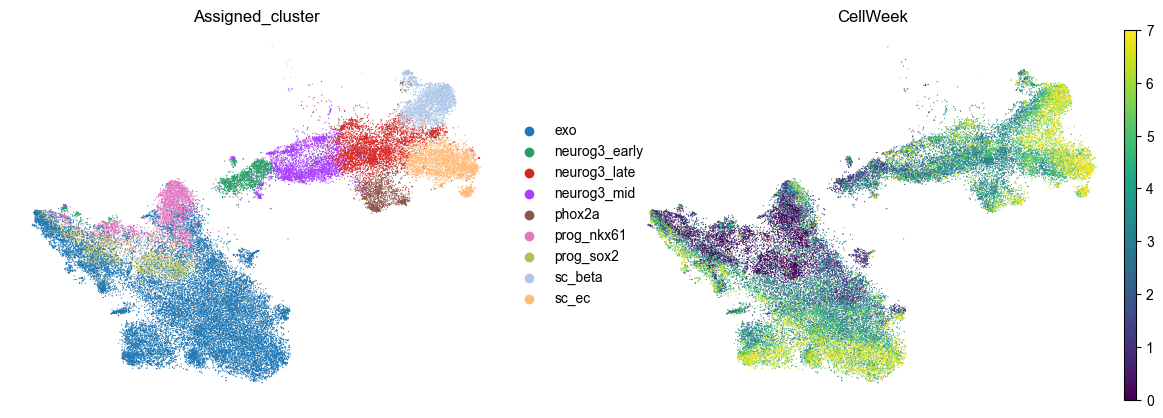

In [6]:

data_dir = '../pygot_data//beta_diff/'
#umap_embedder = load_ParametricUMAP(data_dir + 'parameteric_umap/')
cell_type_key = 'Assigned_cluster'
time_key = 'CellWeek'
embedding_key = 'X_pca'

adata = sc.read_h5ad(data_dir + 'adata_tsne.h5ad') # exclude some outlier cells
adata.obs[time_key] = adata.obs[time_key].astype(int)
path_dir = './benchmark_model/GOT/analysis/veres_2019/'

dim = 10
sc.pl.embedding(adata, basis='tsne',frameon=False, color=['Assigned_cluster', 'CellWeek'])
adata = adata[adata.obs.sort_values(time_key).index]



from scbeta_preprocess import CountsNormalizer, PCAProjection
normalizer = torch.load(data_dir+'/normalizer.pt')
pcaer = torch.load(data_dir+'/pcaer.pt')
normalizer.totals = adata.obs.totals
class scbetaEmbedder:
    def __init__(self, normalizer, pcaer) -> None:
        self.normalizer = normalizer
        self.pcaer = pcaer
    def set_totals(self, totals):
        self.normalizer.totals = totals
    def transform(self, X):
        return self.pcaer.transform(self.normalizer.transform(X.T).T)
embedder = scbetaEmbedder(normalizer, pcaer)
#map_model = pygot.pp.load_map_model(data_dir)

## Loading Model

In [24]:
embedding_key = 'X_pca'
velocity_key = 'velocity_pca'

In [25]:
got_model = torch.load('../pygot_data/beta_diff/model.pkl')

## Velocity Visualization

In [26]:
vis_key = 'tsne'


Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing velocity embedding
    finished (0:00:37) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


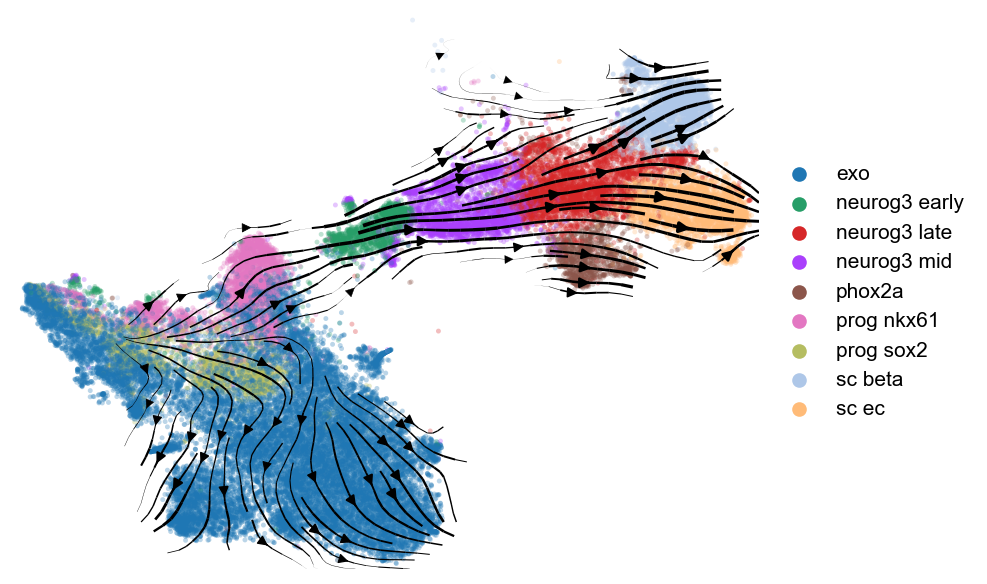

In [27]:
sc.pp.neighbors(adata, use_rep=embedding_key)
adata.layers['velocity'] = pygot.tl.traj.velocity(adata, got_model, A=pcaer.components_, time_key=time_key)
pygot.tl.traj.velocity_graph(adata, embedding_key=embedding_key, velocity_key=velocity_key)
if 'velocity_{}'.format(vis_key) in adata.obsm.keys():
    del adata.obsm['velocity_{}'.format(vis_key)]
scv.pl.velocity_embedding_stream(adata, legend_loc='right margin', color=cell_type_key, dpi=150, title='', basis=vis_key)

## Pseudotime

In [28]:
pm = pygot.tl.analysis.ProbabilityModel()
pm.fit(adata, embedding_key=embedding_key, velocity_key=velocity_key, marginal=False)

Device: cpu


Density Loss 0.0000, Taylor Loss 0.1269: 100%|████████████████████████████████████████████████| 500/500 [01:39<00:00,  5.03it/s]


In [29]:
adata.obs['pseudotime'] = pm.estimate_pseudotime(adata)
adata.obs['variance'] = pm.estimate_variance(adata)

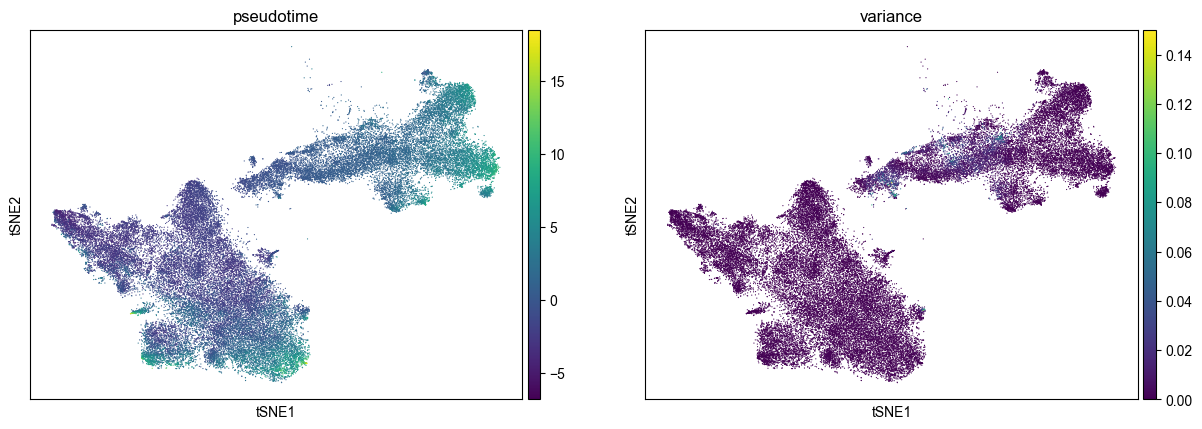

In [30]:
sc.pl.tsne(adata, color=['pseudotime', 'variance'])

## Cell fate quantification

#### predict cell fate

In [31]:
adata.obs['endo_exo'] = adata.obs[cell_type_key].astype(str)
adata.obs.loc[(adata.obs[cell_type_key] != 'exo') & ( ~ adata.obs[cell_type_key].str.startswith('prog')), 'endo_exo'] = 'endo'

In [34]:
cellfate = pygot.tl.analysis.CellFate()
cellfate.fit(adata, embedding_key=embedding_key, velocity_key=velocity_key, cell_type_key='endo_exo',
             target_cell_types = ['endo', 'exo'], mutual=False)

2025-04-15 10:11:43 	 Compute transition roadmap among [0 1]
2025-04-15 10:11:43 	 Compute transition between 0 and 1
2025-04-15 10:11:44 	 Compute velocity graph
2025-04-15 10:11:56 	 Convert into markov chain
2025-04-15 10:11:56 	 Solve abosorbing probabilities
2025-04-15 10:11:57 	 Generate NULL distribution
Export result into adata.obsm['descendant'] and adata.obsm['ancestor']


Text(50.581597222222214, 0.5, 'Current Cell State')

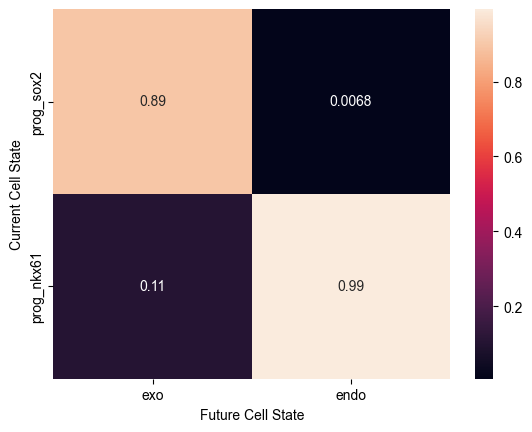

In [35]:
sns.heatmap(cellfate.model.state_map[0]['fbwd'], annot=True)
plt.xlabel('Future Cell State')
plt.ylabel('Current Cell State')


In [42]:
adata.obs['endo'] = adata.obsm['descendant']['endo']
adata.obs['exo'] = adata.obsm['descendant']['exo']

<Axes: xlabel='tSNE1', ylabel='tSNE2'>

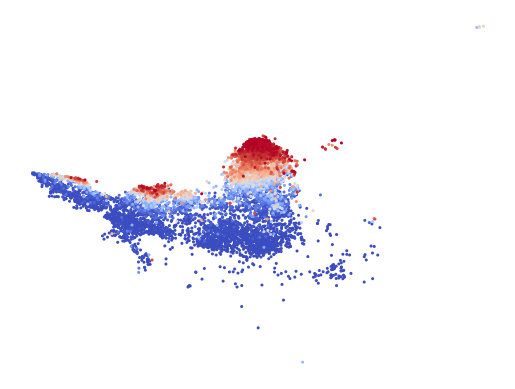

In [38]:
sc.pl.tsne(adata[adata.obs[cell_type_key].isin(['prog_sox2', 'prog_nkx61'])], color=['endo'], cmap='coolwarm', frameon=False, colorbar_loc=None, title='', show=False) 


In [43]:
adata.obs['future_cell_type'] = adata.obsm['descendant'].apply(lambda x : adata.obsm['descendant'].columns[x.argmax()] if x.max() > 0.6 else 'uncertain', axis=1)

In [50]:
adata.uns['log1p']['base'] = None

### EC vs ENDO

In [51]:
exo_endo_adata = adata[~adata.obs['future_cell_type'].str.contains('uncertain')]

[<Axes: xlabel='tSNE1', ylabel='tSNE2'>,
 <Axes: xlabel='tSNE1', ylabel='tSNE2'>]

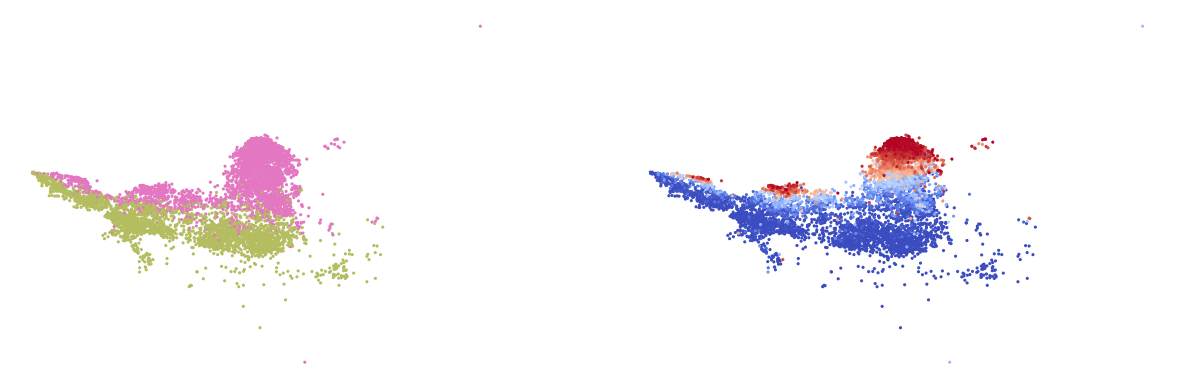

In [52]:
x0_adata = exo_endo_adata[(exo_endo_adata.obs[cell_type_key].isin(['prog_sox2', 'prog_nkx61'])) ]
x0_adata.uns['future_cell_type_colors'] = ['#deb887', '#95d0fc']
x0_adata.obs['fate_bias'] = exo_endo_adata.obs['endo'] / exo_endo_adata.obs[['exo', 'endo']].sum(axis=1)
sc.pl.tsne(x0_adata, color=[cell_type_key] + ['fate_bias'], cmap='coolwarm', frameon=False, legend_loc=None, colorbar_loc=None, title=['', ''], show=False)


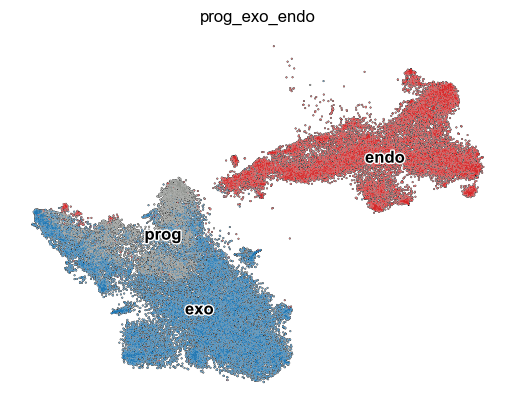

In [53]:
exo_endo_adata.obs['prog_exo_endo'] = exo_endo_adata.obs[cell_type_key].astype(str)
exo_endo_adata.obs.loc[(exo_endo_adata.obs['prog_exo_endo'].str.startswith('prog')), 'prog_exo_endo'] = 'prog'
exo_endo_adata.obs.loc[~exo_endo_adata.obs['prog_exo_endo'].isin(['prog', 'exo']), 'prog_exo_endo'] = 'endo'
exo_endo_adata.uns['prog_exo_endo_colors'] = ['#d62728', '#1f77b4','#929591']
sc.pl.tsne(exo_endo_adata, color='prog_exo_endo', add_outline=True, legend_loc='on data', legend_fontsize=12, legend_fontoutline=2,frameon=False)

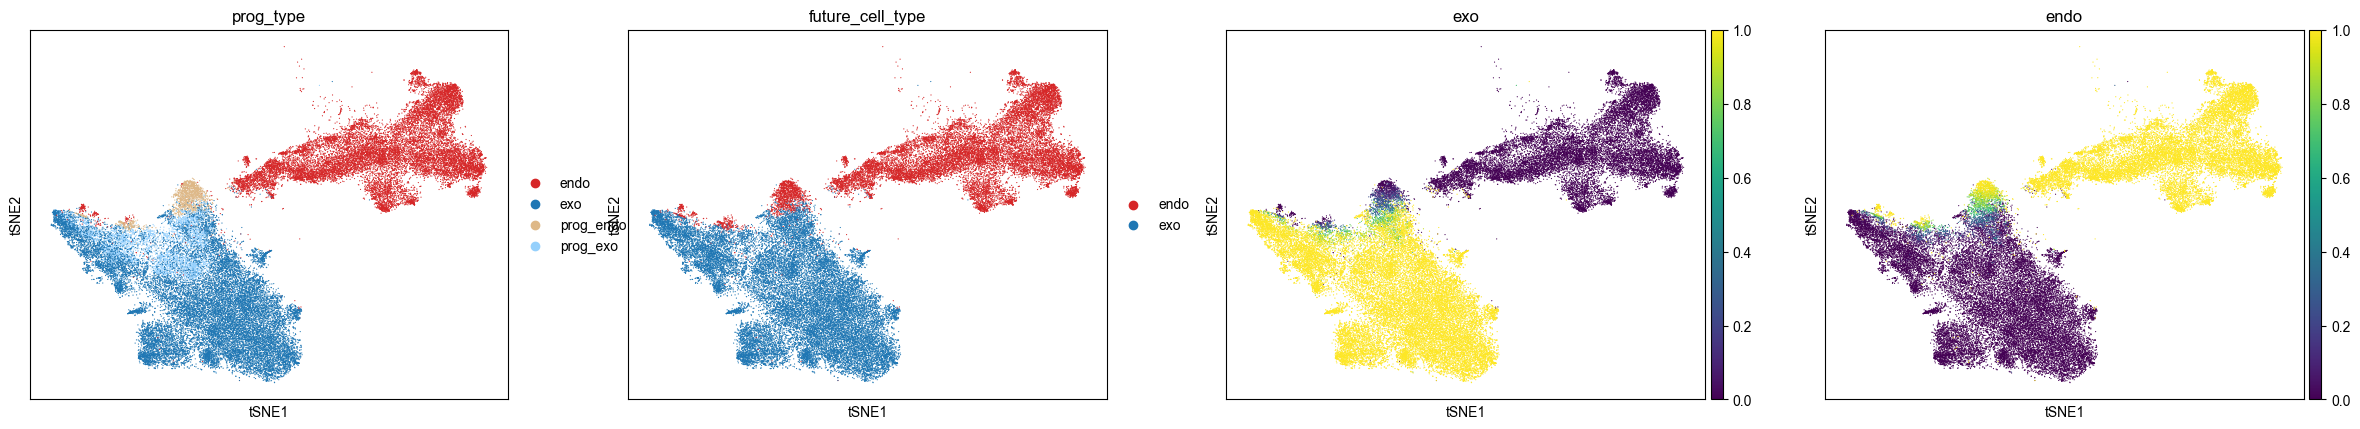

In [54]:
exo_endo_adata.obs['prog_type'] = exo_endo_adata.obs['future_cell_type'].astype(str)
exo_endo_adata.uns['prog_type_colors'] = ['#d62728', '#1f77b4',  '#deb887', '#95d0fc']

exo_endo_adata.uns['future_cell_type_colors'] = ['#d62728','#1f77b4']
exo_endo_adata.obs.loc[x0_adata.obs.index, 'prog_type'] = exo_endo_adata.obs.loc[x0_adata.obs.index]['prog_type'].apply(lambda x : 'prog_'+x)

sc.pl.tsne(exo_endo_adata, color=['prog_type', 'future_cell_type', 'exo', 'endo'])

In [55]:
future_adata = x0_adata

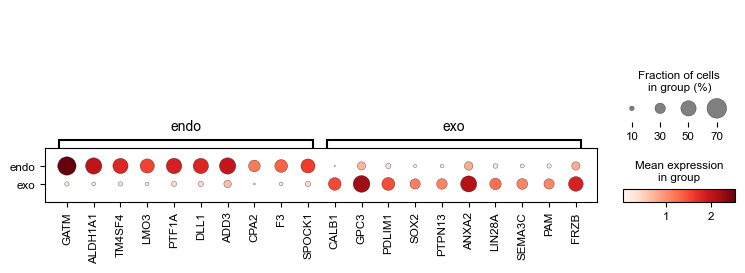

In [56]:
sc.tl.rank_genes_groups(future_adata, groupby='future_cell_type', method='t-test')

sc.tl.filter_rank_genes_groups(future_adata, min_fold_change=1.5, min_in_group_fraction=0.25, max_out_group_fraction=0.25)

sc.tl.dendrogram(future_adata, groupby='future_cell_type')

sc.pl.rank_genes_groups_dotplot(future_adata, key='rank_genes_groups_filtered', dendrogram=True)
#sc.pl.rank_genes_groups_matrixplot(future_adata, key='rank_genes_groups_filtered', cmap='coolwarm')


In [57]:
mature_adata = adata[adata.obs[cell_type_key].isin(['exo','sc_beta','sc_ec'])]
mature_adata.obs['exo_or_endo'] = mature_adata.obs[cell_type_key].astype(str)
mature_adata.obs.loc[mature_adata.obs[cell_type_key] != 'exo', 'exo_or_endo'] = 'endo'

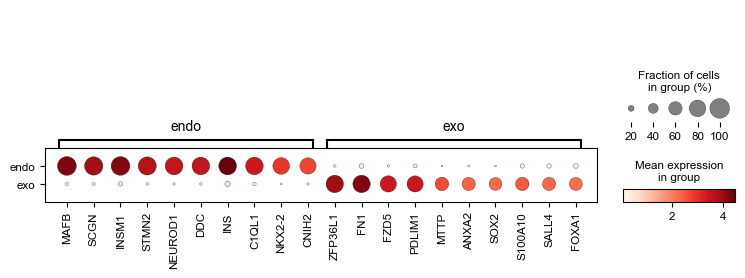

In [58]:
sc.tl.rank_genes_groups(mature_adata, groupby='exo_or_endo', method='wilcoxon')

sc.tl.filter_rank_genes_groups(mature_adata, min_fold_change=1.5, min_in_group_fraction=0.25, max_out_group_fraction=0.25)

sc.pl.rank_genes_groups_dotplot(mature_adata, key='rank_genes_groups_filtered')
#sc.pl.rank_genes_groups_matrixplot(future_adata, key='rank_genes_groups_filtered', cmap='coolwarm')


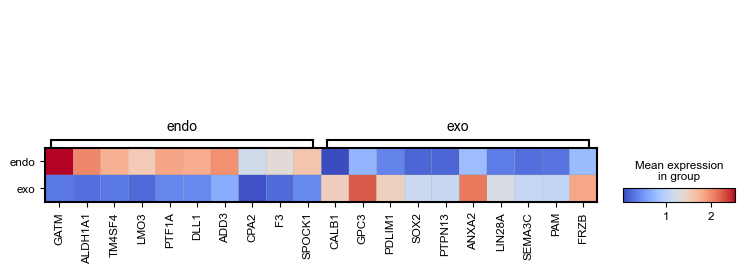

{'mainplot_ax': <Axes: >,
 'color_legend_ax': <Axes: title={'center': 'Mean expression\nin group'}>}

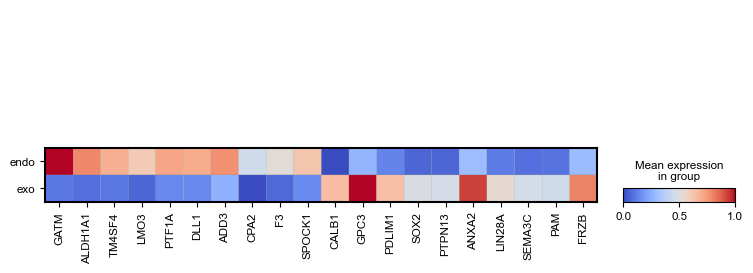

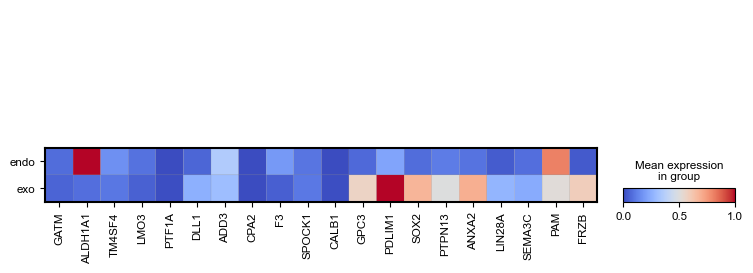

In [59]:
sc.pl.rank_genes_groups_matrixplot(future_adata, key='rank_genes_groups_filtered', dendrogram=True, cmap='coolwarm')
sc.pl.matrixplot(exo_endo_adata[exo_endo_adata.obs['prog_type'].isin(['prog_exo', 'prog_endo'])],  extract_diff_genes(future_adata, 'endo').names[:10].tolist()  + extract_diff_genes(future_adata, 'exo').names[:10].tolist(), 
                 groupby='future_cell_type',  standard_scale='group', cmap='coolwarm', show=False)

sc.pl.matrixplot(mature_adata, extract_diff_genes(future_adata, 'endo').names[:10].tolist()  + extract_diff_genes(future_adata, 'exo').names[:10].tolist(), 
                 standard_scale='group', groupby='future_cell_type', cmap='coolwarm', show=False)



In [60]:
diff_df = sc.get.rank_genes_groups_df(future_adata, 'exo')

In [61]:
exo_endo_adata.var['future_cell_type'] = 'exo'
exo_endo_adata.var.loc[diff_df.loc[diff_df.scores > 0].names.tolist(), 'future_cell_type'] = 'exo'
exo_endo_adata.var.loc[diff_df.loc[diff_df.scores < 0].names.tolist(), 'future_cell_type'] = 'endo'

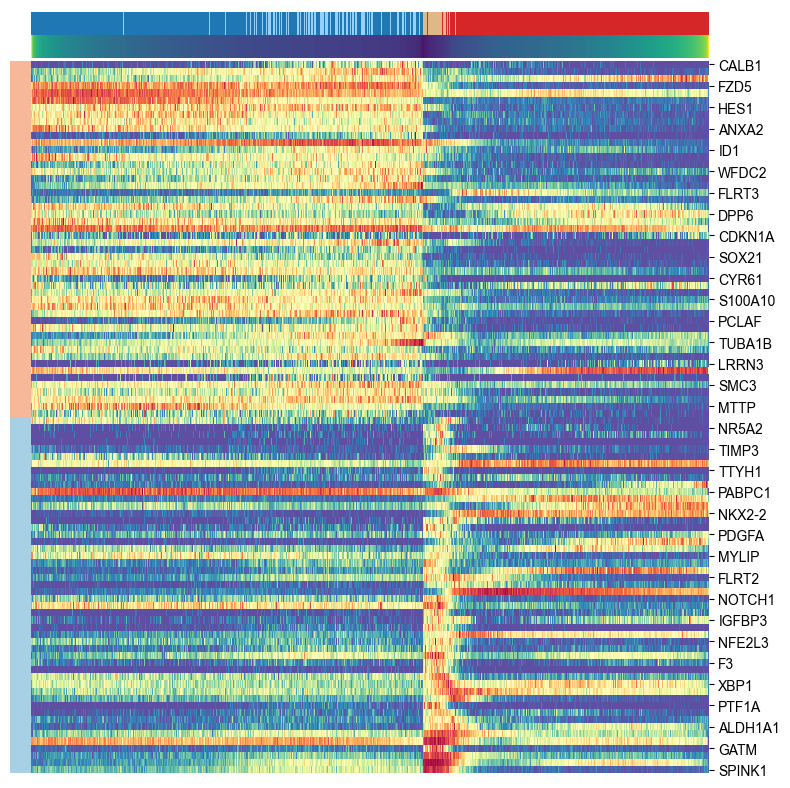

In [64]:

cm, df = bifurcation_heatmap(exo_endo_adata,  diff_df.names[:50].tolist() + diff_df.names[-50:].tolist(),
                    bifurcate_key='future_cell_type',
    b_pool=['exo', 'endo'],
    sortby="pseudotime", col_color=['prog_type', 'pseudotime'], col_cluster=False, row_cluster=False,
                   color_map='Spectral_r',figsize=(8, 8), sort=False, show=False)

In [65]:
endo_adata = exo_endo_adata[exo_endo_adata.obs['future_cell_type'] == 'endo']

In [66]:
from sklearn.preprocessing import minmax_scale

def simplify(adata, df, key_list, step=20):
    def process(obs_list, key_list):
        sub_obs = adata.obs.loc[obs_list]
        res = []
        for key in key_list:
            vals = sub_obs[key].tolist()
            if isinstance(vals[0], (int, float)):
                res.append(np.mean(vals))
            elif isinstance(vals[0], (str)):
                res.append(max(vals,key=vals.count))
        return res
    meta = []
    for i in range(0, df.shape[1], step):
        meta.append(process(df.columns[i:i+step], key_list ))
    sdf = []
    for i in range(0, df.shape[1], step):
        sdf.append(df.values[:,i:i+step].mean(axis=1))
    meta = pd.DataFrame(meta, columns=key_list)
    sdf = pd.DataFrame(np.array(sdf).T, index=df.index)
    return meta, sdf

In [67]:
df1 = df[df.columns[(exo_endo_adata.obs.loc[df.columns, 'future_cell_type'] == 'exo').tolist()]]
df2 = df[df.columns[(exo_endo_adata.obs.loc[df.columns, 'future_cell_type'] != 'exo').tolist()]]
meta1, sdf1 = simplify(exo_endo_adata, df1, ['pseudotime', 'prog_type'])
meta1['pseudotime'] = minmax_scale(meta1['pseudotime'])
meta2, sdf2 = simplify(exo_endo_adata, df2, ['pseudotime', 'prog_type'])
meta2['pseudotime'] = minmax_scale(meta2['pseudotime'])
meta = pd.concat([meta1, meta2]).reset_index(drop=True)
sdf = pd.concat([sdf1, sdf2], axis=1)
sdf = pd.DataFrame(minmax_scale(sdf, axis=1), index=sdf.index)
row_split = len(meta1)
print(row_split)

1231


In [68]:
genes = sc.get.rank_genes_groups_df(future_adata, 'exo', key='rank_genes_groups_filtered' ).names
genes1 = genes[genes == genes][:10]
genes = sc.get.rank_genes_groups_df(future_adata, 'endo', key='rank_genes_groups_filtered' ).names
genes2 = genes[genes == genes][:10]

annotated_genes = list(genes1) + list(genes2)
annotated_genes

['CALB1',
 'GPC3',
 'PDLIM1',
 'SOX2',
 'PTPN13',
 'ANXA2',
 'LIN28A',
 'SEMA3C',
 'PAM',
 'FRZB',
 'GATM',
 'ALDH1A1',
 'TM4SF4',
 'LMO3',
 'PTF1A',
 'DLL1',
 'ADD3',
 'CPA2',
 'F3',
 'SPOCK1']

In [39]:
sdf.to_csv('/disk/xuruihong/tmp.csv')
meta.to_csv('/disk/xuruihong/tmp2.csv')

In [ ]:
# In R
'''
library(ComplexHeatmap)
library(viridis)
library(circlize)
library(grid)
library(RColorBrewer)

# 读取数据
A <- read.csv('/disk/xuruihong/tmp.csv', row.names = 1)
A <- as.matrix(A)

meta <- read.csv('/disk/xuruihong/tmp2.csv', row.names = 1)
samples <- meta$prog_type
pseudotime <- meta$pseudotime  # 伪时间信息

# 生成 Spectral colormap（用于热图的值）
spectral_col_fun <- colorRamp2(
  seq(min(A), max(A), length.out = 11),  
  rev(brewer.pal(11, "Spectral"))  
)

# 颜色映射定义（细胞状态）
cell_state_colors <- c(
  'endo' = '#d62728', 
  'exo' = '#1f77b4', 
  'prog_endo' = '#deb887', 
  'prog_exo' = '#95d0fc'
)

# 生成 viridis colormap 的映射函数（用于 pseudotime）
pseudotime_col_fun <- colorRamp2(
  seq(min(pseudotime), max(pseudotime), length.out = 20),  
  viridis(20)  
)



top_annotation <- HeatmapAnnotation(
  CellState = samples,
  Pseudotime = pseudotime,
  col = list(CellState=cell_state_colors, Pseudotime=pseudotime_col_fun),
  #show_annotation_name = TRUE,  # 启用注释名称
  #annotation_name_gp = gpar(fontsize = 10, fontface = "bold"),  # 调整字体
  height = unit(2.5, "mm")  # 增加高度以便显示
  )

row_split_no = 50
col_split_no = 1236
# 自定义行分割标签
row_split_groups <- c(rep("Prog Exo DEG", row_split_no), rep("Prog Endo DEG", nrow(A)-row_split_no))  # 可改成你的分组名称

row_colors <- c(
  'Prog Exo DEG' = "#95d0fc", 
  'Prog Endo DEG' = "#deb887"
)

row_group_anno <- rowAnnotation(
  Group = row_split_groups,
  col=list(Group=row_colors),
  width = unit(4, "mm"),
  show_legend = FALSE
)

# 需要标注的基因列表
genes <- c(
  'CALB1',
  'GPC3',
  'ANXA2',
  'PTPN13',
  'SOX2',
  'PDLIM1',
  'LIN28A',
  'SEMA3C',
  'PAM',
  'COL9A3',
  'GATM',
  'ALDH1A1',
  'LMO3',
  'TM4SF4',
  'DLL1',
  'PTF1A',
  'ADD3',
  'CPA2',
  'F3',
  'SPOCK1'
)

# 创建行标注 (基因名称)
row_anno <- rowAnnotation(
  link = anno_mark(
    at = which(rownames(A) %in% genes), 
    labels = rownames(A)[rownames(A) %in% genes], 
    labels_gp = gpar(fontsize = 10)
  )
)
?Heatmap

# 生成热图对象
ht <- Heatmap(A,
              name = "Scaled Exp",
              col = spectral_col_fun, 
              #row_title_gp = gpar(fontsize = 4),
              show_row_names = F, 
              show_column_names = FALSE,
              cluster_rows = T,   # 允许行聚类
              cluster_columns = FALSE,
              row_split = row_split_groups,  # 自定义行拆分
              top_annotation = top_annotation,  
              right_annotation = row_anno,  # 右侧基因标注
              left_annotation = row_group_anno,  # 左侧分组注释
              column_title = c('To Exo Lineage', 'To Endo Lineage'),
              
              
              column_split = c(rep(1, col_split_no), rep(2, ncol(A) - col_split_no)),  # 仍然按列拆分
              row_gap = unit(1.5, "mm"),
              column_gap = unit(1.5, "mm")
             
)

# 保存绘制的热图
pdf(file="~/Fig5_heatmap.pdf", width=10, height=8)
draw(ht , heatmap_legend_side = "right", annotation_legend_side = "left")
dev.off()

'''

In [69]:
exo_adata = exo_endo_adata[exo_endo_adata.obs['future_cell_type']== 'exo']
endo_adata = exo_endo_adata[exo_endo_adata.obs['future_cell_type']== 'endo']


In [70]:
prog_endo_adata = exo_endo_adata[exo_endo_adata.obs[cell_type_key].isin(['prog_nkx61', 'prog_sox2', 'neurog3_early' ])]
prog_endo_adata = prog_endo_adata[prog_endo_adata.obs[time_key].astype(int) < 2]

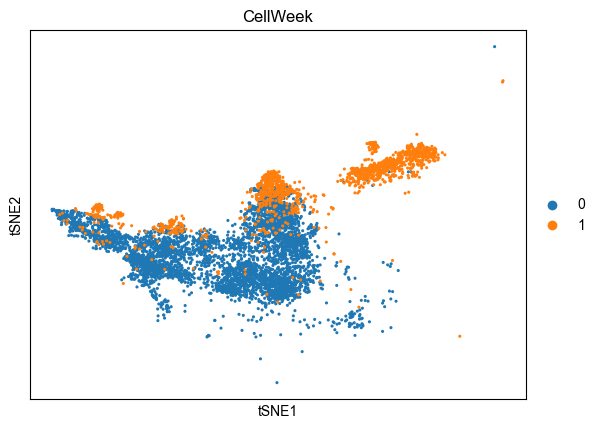

In [71]:
sc.pl.tsne(prog_endo_adata[prog_endo_adata.obs[time_key].astype(int) < 2], color=time_key)

#### GRN analysis

In [72]:
prog_adata = sc.concat([
    adata[adata.obs[cell_type_key].isin(['prog_sox2', 'prog_nkx61'])],
    adata[(adata.obs['pseudotime'] < np.quantile(adata[adata.obs[cell_type_key] == 'neurog3_early'].obs['pseudotime'], .25)) & \
    (adata.obs[cell_type_key] == 'neurog3_early')],
    adata[(adata.obs['pseudotime'] < np.quantile(adata[adata.obs[cell_type_key] == 'exo'].obs['pseudotime'], .25)) & \
    (adata.obs[cell_type_key] == 'exo')]
])

In [73]:
grn_fitter = pygot.tl.analysis.GRN()
prog_grn = grn_fitter.fit(prog_adata, species='human', non_negative=True, n_epoch=10000, l1_penalty=0.0025)

TF number: 236, Index(['SNAI2', 'EGR2', 'GFI1', 'FOXC1', 'ARX', 'PHOX2B', 'PITX2', 'HOXB7',
       'PAX6', 'PAX4',
       ...
       'MELK', 'NANOS1', 'NEUROG3', 'PHLDA2', 'PPARGC1A', 'RUFY3', 'SLC18A1',
       'TAGLN2', 'TFF3', 'TPI1'],
      dtype='object', length=236)
scale velocity with factor : 76.01415384359849
l1_penalty: 0.0025 min_beta: 1.0


Epoch [10000/10000], Train Loss: 54.4135, Val Loss: 88.0031: 100%|████████████████████████| 10000/10000 [08:42<00:00, 19.15it/s]


In [74]:
ranked_edges = get_ranked_edges(prog_grn.G, prog_grn.tf_names, prog_grn.gene_names, cutoff=0.1)

NameError: name 'get_ranked_edges' is not defined

In [1279]:
def get_ranked_edges(jacobian, tf_names, gene_names, cutoff=1e-5):
    
        
    df = pd.DataFrame(jacobian, index=gene_names, columns=tf_names).T
    stacked = df.stack()
    values = stacked.to_numpy().flatten()
    idx = np.argsort(abs(values))[::-1]
    
    num_top = np.sum(abs(jacobian) > cutoff)
    
    top_idx = idx[:num_top]
    gene1 = tf_names[top_idx // len(gene_names)]
    gene2 = gene_names[top_idx % len(gene_names)]
    result = pd.DataFrame([gene1, gene2, values[top_idx]], index=['Gene1', 'Gene2', 'EdgeWeight']).T
    result['absEdgeWeight'] = abs(result.EdgeWeight)
    result = result.sort_values('absEdgeWeight', ascending=False)
    return result

In [45]:
ranked_edges = prog_grn.ranked_edges.loc[prog_grn.ranked_edges.EdgeWeight > 0.1]

In [1281]:
important_TF = ranked_edges.groupby('Gene1').apply(lambda x: x.EdgeWeight.sum()).sort_values().tail(25)

In [1282]:
important_TF

Gene1
PROX1        9.132960
PTF1A        9.767812
SMC3         9.855821
EGR1        12.330640
CBFA2T2     14.911809
HMGA1       17.323170
MECOM       17.759438
HMGA2       22.470575
HES1        24.242725
ONECUT2     26.856363
GADD45A     27.043684
FOS         27.322845
SOX2        31.777344
HEY1        32.257721
SOX9        39.692318
PDX1        40.483040
NKX6-1      47.312611
STAT1       50.500107
HMGB1       80.175331
XBP1        81.885689
NKX2-2      85.105316
ID1        100.955872
NEUROG3    109.197952
SOX4       166.562851
INSM1      260.462921
dtype: float32

In [1283]:
ranked_edges['EdgeWeight'] = np.log(ranked_edges['EdgeWeight'].to_numpy().astype(float)+1)

In [1284]:
ranked_edges['edge'] = ranked_edges.apply(lambda x: x.Gene1 + '->' + x.Gene2, axis=1)

In [1288]:
ranked_edges = ranked_edges.set_index('edge')

In [1285]:
g1 = ranked_edges.Gene1.unique()
g2 = ranked_edges.Gene2.unique()
show_G = np.zeros(shape=(len(g1), len(g2)))
show_G.shape

(50, 731)

In [1292]:
for i, g in tqdm(enumerate(g1)):
    for j, k in enumerate(g2):
        if (g+'->'+k) in ranked_edges.index:
            show_G[i, j] = ranked_edges.loc[g+'->'+k].EdgeWeight
            #show_G[i, j] = 1


50it [00:00, 144.31it/s]


In [1293]:
show_G = pd.DataFrame(show_G, index=g1, columns=g2)

In [1294]:
genes = important_TF

In [1295]:
prog_diff_df = sc.get.rank_genes_groups_df(future_adata, 'exo')
def isdeg(x):
    if (abs(x.logfoldchanges) > 1.) and (x.pvals_adj < 0.01):
        return True
    else:
        return False
tmp_ad = exo_endo_adata[exo_endo_adata.obs[cell_type_key].isin(['neurog3_early', 'exo'])]
sc.tl.rank_genes_groups(tmp_ad, groupby='future_cell_type')
mature_diff_df = sc.get.rank_genes_groups_df(tmp_ad, 'exo')
prog_diff_df['type'] = prog_diff_df.scores.apply(lambda x: 'exo' if x > 0 else 'endo')
prog_diff_df['type'] = prog_diff_df.apply(lambda x: x['type'] if isdeg(x)  else 'ns', axis=1)
mature_diff_df['type'] = mature_diff_df.scores.apply(lambda x: 'exo' if x > 0 else 'endo')
mature_diff_df['type'] = mature_diff_df.apply(lambda x: x['type'] if isdeg(x)  else 'ns', axis=1)

target_meta = pd.concat([prog_diff_df.set_index('names').loc[g2]['scores'] ,
mature_diff_df.set_index('names').loc[g2]['scores'] ], axis=1)
target_meta.columns = ['Prog stage', 'Mature stage']

In [1296]:
target_meta = target_meta.loc[((abs(target_meta['Prog stage']) > 10)  | (abs(target_meta['Mature stage']) > 10)) & (show_G.sum(axis=0) > 1.)]

In [1297]:
idx = target_meta.sum(axis=1).sort_values().index

In [1298]:
target_meta.loc[idx].to_csv('../pygot_data/beta_diff/endo_exo_grn_binary_meta.txt', sep='\t')

In [1299]:
show_G.loc[genes.index][idx].to_csv('../pygot_data/beta_diff/endo_exo_grn_binary.txt', sep='\t')

In [1251]:
show_G.sum(axis=1).sort_values()[-25:]

EGR1         1.175587
GADD45A      1.588222
SOX11        2.085769
HSPA5        2.186628
PTF1A        2.379263
MECOM        3.116815
SMC3         4.184286
FOS          5.646068
HEY1         6.039483
NKX2-2       8.556091
SOX2         9.973821
ONECUT2     10.472786
HMGA2       12.127352
HES1        12.174778
NKX6-1      12.841552
HMGA1       16.175752
NEUROG3     16.789167
SOX9        19.515837
PDX1        20.017645
STAT1       23.490488
XBP1        35.127365
ID1         53.255889
HMGB1       84.008688
INSM1       89.108347
SOX4       137.358572
dtype: float64

In [1300]:
ranked_edges.to_csv('../pygot_data/beta_diff/endo_exo_grn.txt', sep='\t',index=False)

In [1514]:
toscenic_grn = prog_grn.ranked_edges.loc[prog_grn.ranked_edges.EdgeWeight > 0.0001]
toscenic_grn = toscenic_grn[toscenic_grn.columns[:3]]
toscenic_grn.columns = ['TF', 'target', 'importance']
toscenic_grn.reset_index(drop=True).to_csv('/storage/xuruihong/repository/scenic_test/adj.got.tsv', sep='\t', index=False)

In [1463]:
adata_raw = sc.AnnData(prog_endo_adata.X, obs=prog_endo_adata.obs, var=prog_endo_adata.var)
row_attrs = {"Gene": np.array(adata_raw.var_names),};
col_attrs = {"CellID": np.array(adata_raw.obs_names)};
import loompy as lp
lp.create("../scenic_test/adata_raw.loom", adata_raw.X.transpose(),row_attrs,col_attrs);

In [ ]:
#In shell 
#docker run -it --rm -v ./:/scenicdata  aertslab/pyscenic:0.12.1 pyscenic grn --num_workers 20 --output /scenicdata/adj.sample.tsv --method grnboost2 /scenicdata/adata_raw.loom /scenicdata/scenic_data/allTFs_hg38.txt
#docker run -it --rm -v ./:/scenicdata  aertslab/pyscenic:0.12.1 pyscenic   ctx /scenicdata/adj.sample.tsv /scenicdata/scenic_data/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather --annotations_fname /scenicdata/scenic_data/motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl --expression_mtx_fname /scenicdata/adata_raw.loom --mode "dask_multiprocessing" --output /scenicdata/reg.csv --num_workers 10  --mask_dropouts
#docker run -it --rm -v ./:/scenicdata  aertslab/pyscenic:0.9.18 pyscenic aucell /scenicdata/adata_raw.loom /scenicdata/reg.csv --output /scenicdata/adata_processed.loom --num_workers 5

In [1536]:
f_final_loom = '../scenic_test/adata_processed3.loom'

In [1537]:
import json
import zlib
import base64
# scenic output
lf = lp.connect( f_final_loom, mode='r', validate=False )
#meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
auc_mtx['cell_type'] = prog_endo_adata.obs.loc[auc_mtx.columns]

In [1538]:
adata_sc = sc.AnnData(auc_mtx, obs=prog_endo_adata.obs)

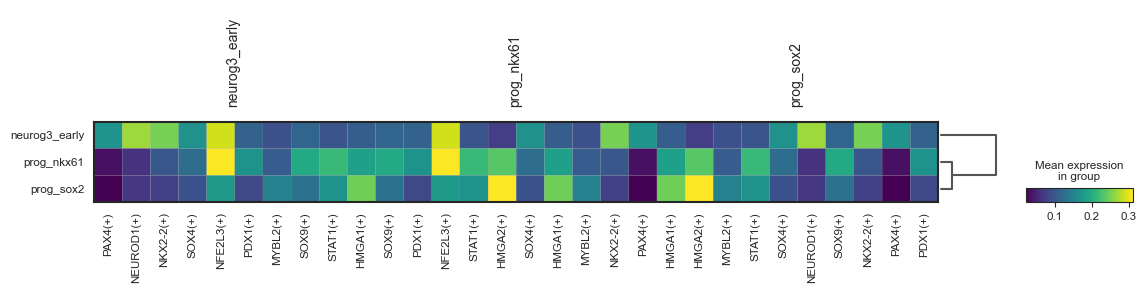

In [1522]:
sc.tl.rank_genes_groups(adata_sc , groupby=cell_type_key)
sc.pl.rank_genes_groups_matrixplot(adata_sc, groupby=cell_type_key)

### SC-beta vs SC-EC

In [61]:
endo_adata = adata[~adata.obs[cell_type_key].isin(['exo','prog_sox2', 'prog_nkx61']) & (adata.obs[time_key].astype(int) >= 2)]

In [65]:
cellfate = pygot.tl.analysis.CellFate()
cellfate.fit(endo_adata, embedding_key=embedding_key, velocity_key=velocity_key, cell_type_key=cell_type_key,
             target_cell_types = ['sc_beta', 'sc_ec', 'phox2a'], mutual=False)

2025-02-25 15:22:18      Compute transition roadmap among [0 1]

2025-02-25 15:22:18      Compute transition between 0 and 1

2025-02-25 15:22:18      Compute velocity graph

2025-02-25 15:22:26      Convert into markov chain

2025-02-25 15:22:26      Solve abosorbing probabilities

2025-02-25 15:22:27      Generate NULL distribution

Export result into adata.obsm['descendant'] and adata.obsm['ancestor']

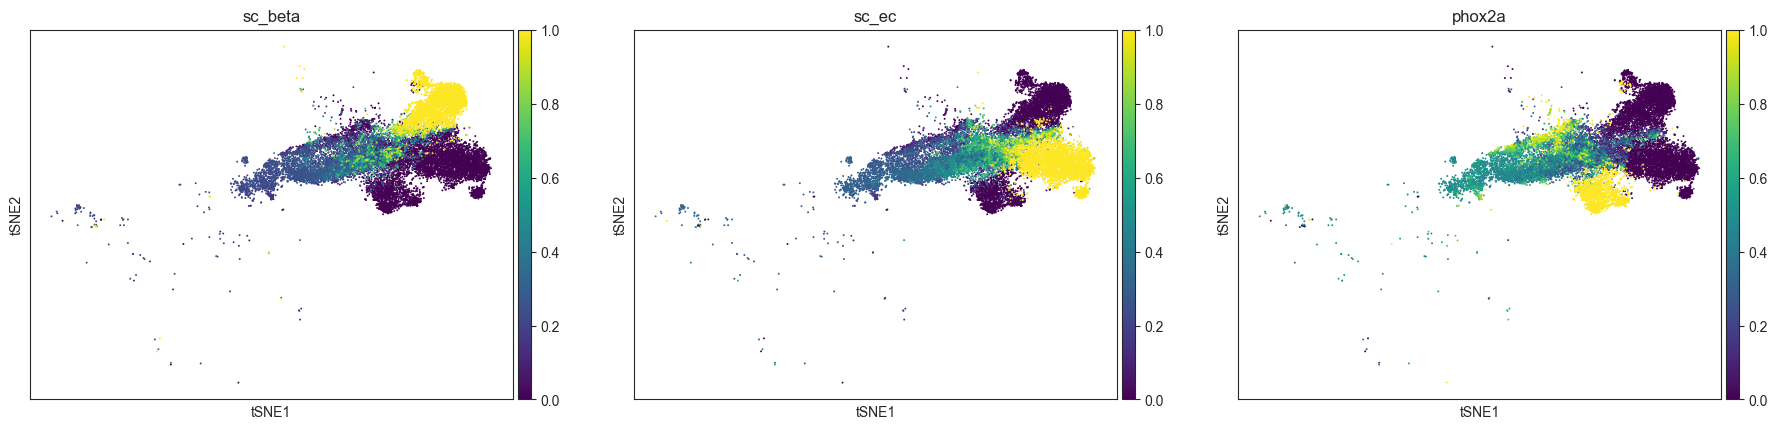

In [66]:
pygot.pl.plot_cell_fate_embedding(endo_adata, color=['sc_beta', 'sc_ec', 'phox2a'], basis='tsne')
endo_adata.obs[endo_adata.obsm['descendant'].columns] = endo_adata.obsm['descendant']

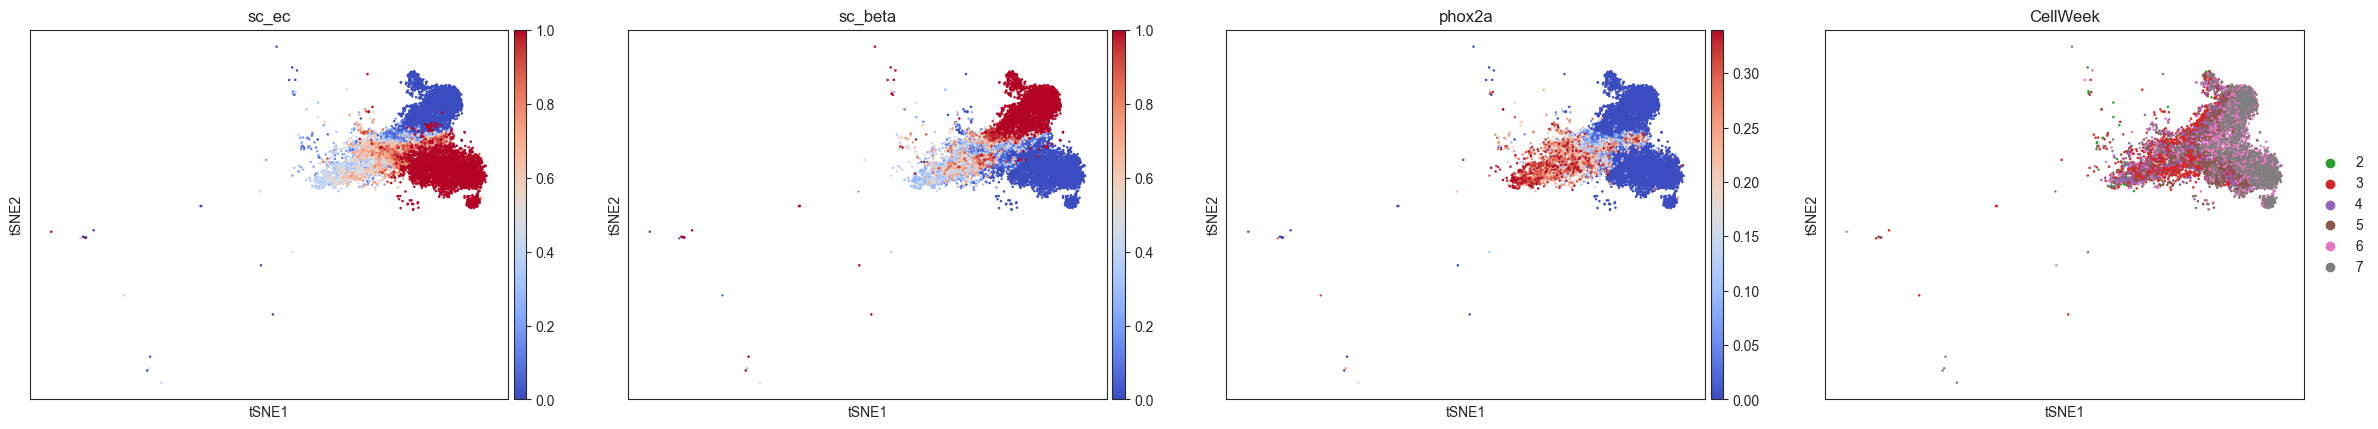

In [68]:
time_key = 'CellWeek'
endo_adata = endo_adata[(endo_adata.obs['sc_beta'] + endo_adata.obs['sc_ec']) > 0.66]
sc.pl.tsne(endo_adata, color=['sc_ec', 'sc_beta', 'phox2a', time_key], cmap='coolwarm')

In [9]:
endo_adata

AnnData object with n_obs × n_vars = 10021 × 1948
    obs: 'Assigned_cluster', 'Assigned_subcluster', 'tSNE_dim1', 'tSNE_dim2', 'Differentiation', 'CellWeek', 'Lib_prep_batch', 'Indrops_barcode_sequence', 'totals', 'ent', 'dpt_pseudotime', 'idx', 'dv(INSM1)/dNEUROG3', 'dv(NEUROG3)/dNEUROG3', 'dv(NEUROG3)/dSOX4', 'root_cells', 'exo', 'endo', 'sc_beta', 'sc_ec', 'phox2a', 'future_cell_type', 'pseudotime', 'variance', 'beta_ec_fate_bias', 'global_grn_fit_godness'
    var: 'idx'
    uns: 'Assigned_cluster_colors', 'CellWeek_colors', 'diffmap_evals', 'fate_prob', 'fate_std', 'gene_name', 'iroot', 'log1p', 'neighbors', 'tf_name', 'umap', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_diffmap', 'X_grn', 'X_pca', 'X_pumap', 'X_tsne', 'X_umap', 'velocity', 'velocity_grn', 'velocity_pca', 'velocity_pumap', 'velocity_tsne', 'velocity_umap'
    layers: 'Ms', 'Mu', 'imputed_count', 'raw', 'raw_count', 'scaled_velocity', 'spliced', 'unspliced', 'velocity'
    obsp: 'connectivities', 'distances'

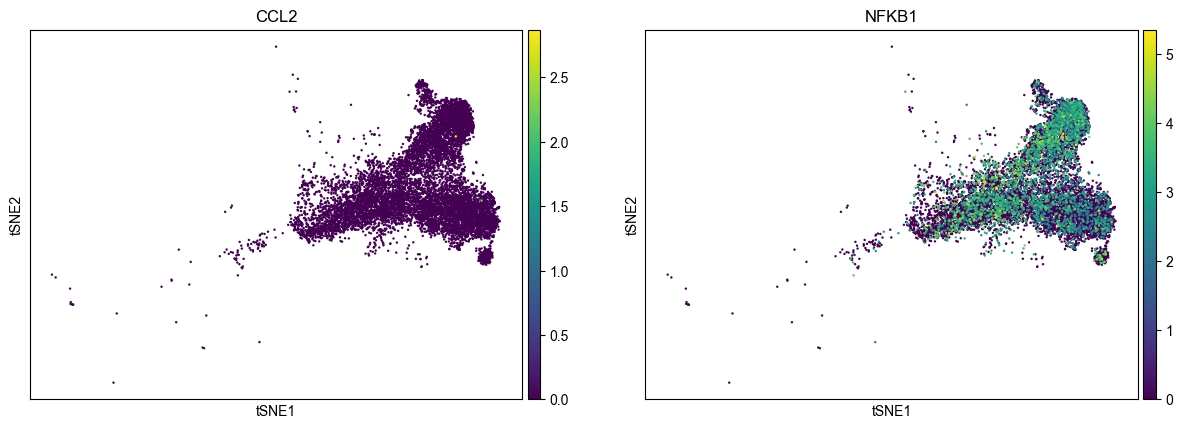

In [23]:
sc.pl.tsne(endo_adata, color=['CCL2', 'NFKB1'], )

In [76]:

endo_adata.obs['beta_ec_fate_bias'] = endo_adata.obs['sc_beta'] / endo_adata.obs[['sc_beta', 'sc_ec']].sum(axis=1).to_numpy()
endo_adata.obs['future_cell_type'] = endo_adata.obs[['sc_ec', 'sc_beta']].apply(lambda x: ['sc_ec', 'sc_beta'][x.argmax()]  if x.max() > 0.75 else 'uncertain', axis=1)

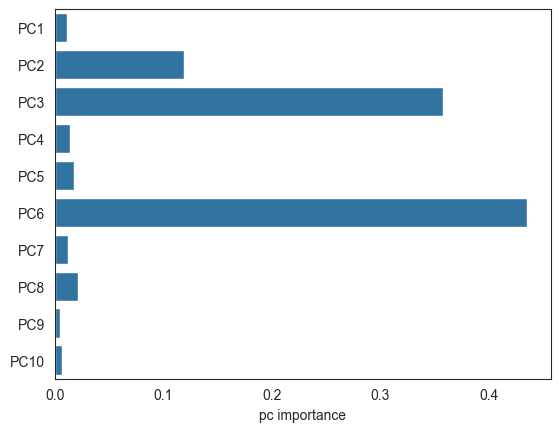

In [1414]:
X = endo_adata[endo_adata.obs['future_cell_type'] != 'uncertain'].obsm['X_pca']
y = endo_adata[endo_adata.obs['future_cell_type'] != 'uncertain'].obs['future_cell_type'].replace({'sc_ec':0, 'sc_beta':1}).to_numpy()
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
classifier = RandomForestClassifier()
classifier.fit(X,y)
sns.barplot( x=classifier.feature_importances_,y=['PC'+str(i+1) for i in range(10)])
plt.xlabel('pc importance')
gene_importance = pcaer.components_.T @ classifier.feature_importances_
pos_gene_idx = adata.var.index[np.argsort(gene_importance)[-100:]]
neg_gene_idx = adata.var.index[np.argsort(gene_importance)[:100]]


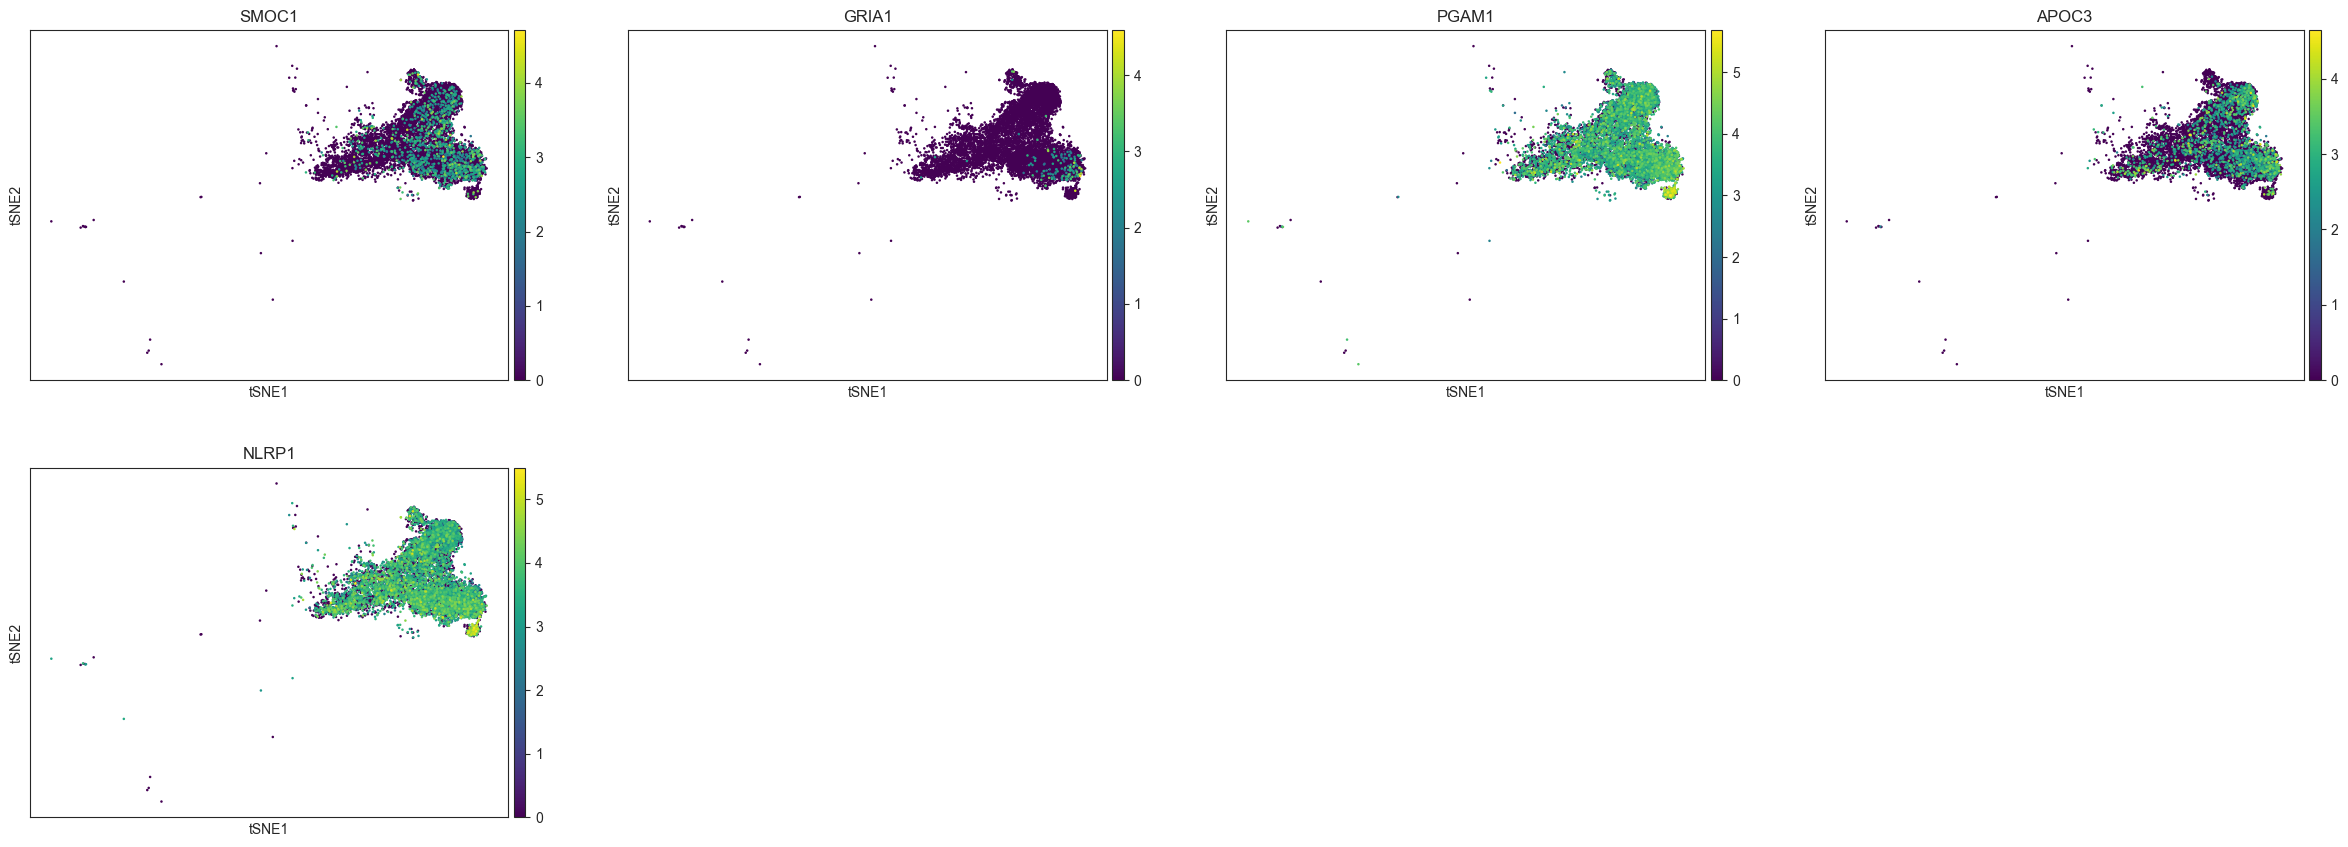

In [1416]:
sc.pl.tsne(endo_adata, color=neg_gene_idx[-5:])

In [71]:
from sklearn.decomposition import PCA
pca_orth = PCA(n_components=2)
endo_adata.obsm['X_emb'] = pca_orth.fit_transform(endo_adata.obsm['X_pca'][:,[1,2,5]])
endo_adata.obsm['X_emb'] = endo_adata.obsm['X_emb'][:,[1,0]]
endo_adata.obsm['X_emb'][:,0] = -endo_adata.obsm['X_emb'][:,0]
orth_comp = pca_orth.components_ @ pcaer.components_[[1,2,5],:]

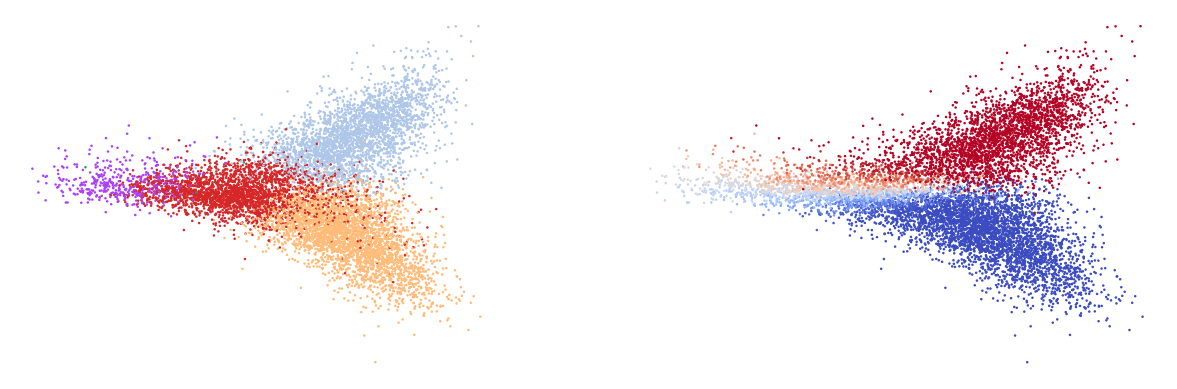

In [1200]:
sc.pl.embedding(endo_adata, basis='emb',
                color=[cell_type_key,  'beta_ec_fate_bias'], frameon=False,
                cmap='coolwarm', projection='2d', colorbar_loc=None, legend_loc=None, title=['', ''], show=False)


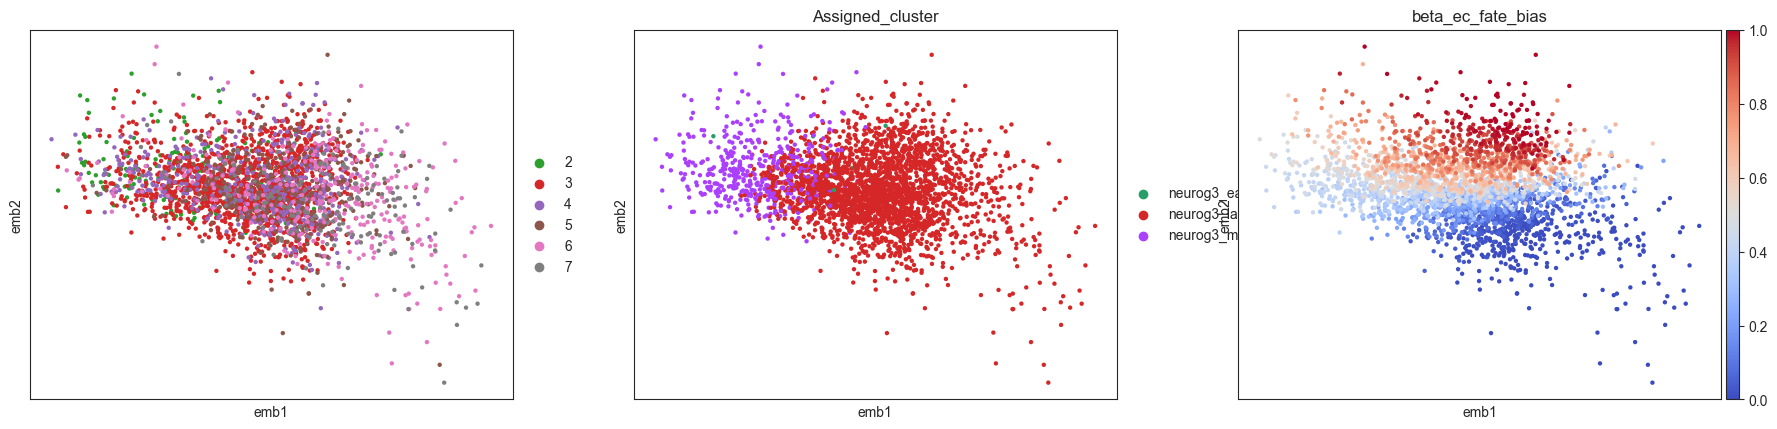

In [1397]:
prog_endo_adata = endo_adata[(~endo_adata.obs[cell_type_key].isin(['sc_beta','sc_ec']))]

sc.pl.embedding(prog_endo_adata, basis='emb',
                color=[time_key, cell_type_key,  'beta_ec_fate_bias'],cmap='coolwarm', title='', frameon=True,  )


In [1426]:
prog_endo_adata = endo_adata[(~endo_adata.obs[cell_type_key].isin(['sc_beta','sc_ec', 'phox2a'])) & (endo_adata.obs['future_cell_type'] != 'uncertain')]
prog_endo_adata = prog_endo_adata[prog_endo_adata.obs[time_key].astype(int) < 4 ]

{'mainplot_ax': <Axes: >,
 'gene_group_ax': <Axes: >,
 'color_legend_ax': <Axes: title={'center': 'Mean expression\nin group'}>}

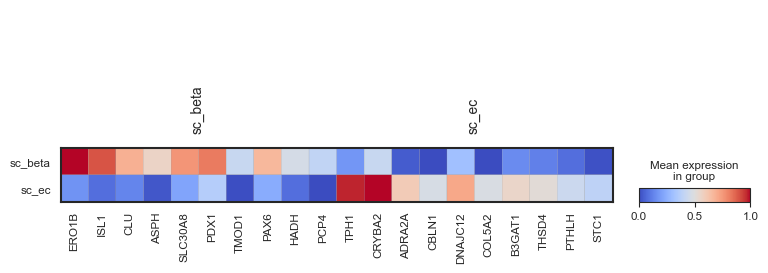

In [1427]:
col_colors_df = pd.DataFrame({"Condition": ["#FF5733", "#33FF57", "#3357FF"]})
mature_endo_adata = adata[adata.obs[cell_type_key].isin(['sc_beta','sc_ec'])]

sc.tl.rank_genes_groups(mature_endo_adata, groupby=cell_type_key, method='wilcoxon')

sc.tl.filter_rank_genes_groups(mature_endo_adata, min_in_group_fraction=0.25, max_out_group_fraction=0.5)


sc.pl.rank_genes_groups_matrixplot(mature_endo_adata, key='rank_genes_groups_filtered', cmap='coolwarm', show=False, standard_scale='group')


{'mainplot_ax': <Axes: >,
 'color_legend_ax': <Axes: title={'center': 'Mean expression\nin group'}>}

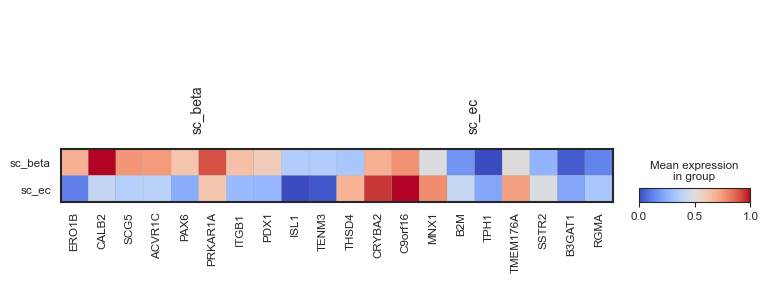

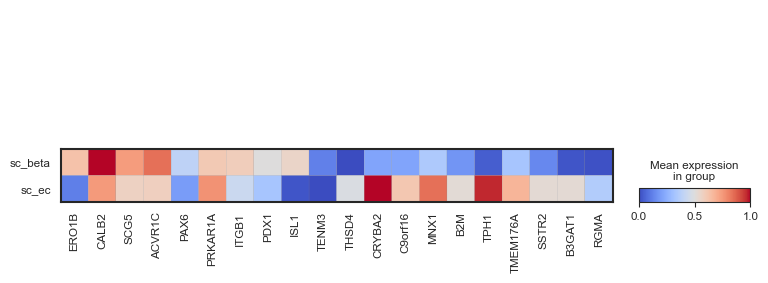

In [1428]:
sc.tl.rank_genes_groups(prog_endo_adata, groupby='future_cell_type', method='wilcoxon')

sc.tl.filter_rank_genes_groups(prog_endo_adata, min_in_group_fraction=0.25, max_out_group_fraction=0.75)

sc.pl.rank_genes_groups_matrixplot(prog_endo_adata, key='rank_genes_groups_filtered',   standard_scale='group', show=False, cmap='coolwarm')

sc.pl.matrixplot(mature_endo_adata,  extract_diff_genes(prog_endo_adata, 'sc_beta').names[:10].tolist()  + extract_diff_genes(prog_endo_adata, 'sc_ec').names[:10].tolist(), 
                 groupby=cell_type_key, standard_scale='group', cmap='coolwarm', show=False)




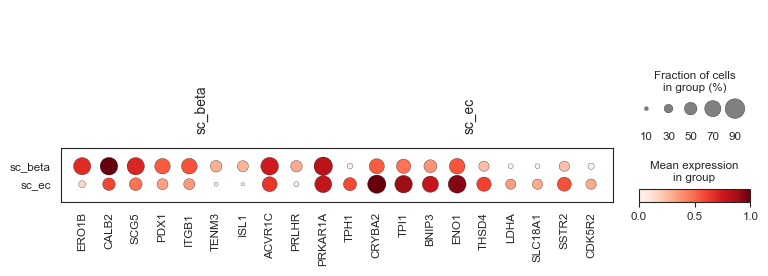

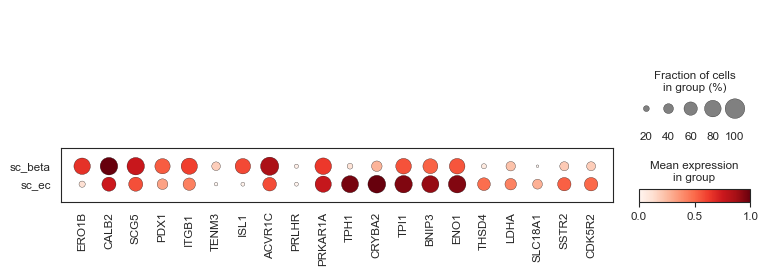

In [82]:
sc.tl.rank_genes_groups(prog_endo_adata, groupby='future_cell_type', method='wilcoxon')

sc.tl.filter_rank_genes_groups(prog_endo_adata, min_in_group_fraction=0.25, max_out_group_fraction=0.75)


sc.pl.rank_genes_groups_dotplot(prog_endo_adata, key='rank_genes_groups_filtered',   standard_scale='group', show=False)
sc.pl.dotplot(mature_endo_adata,  extract_diff_genes(prog_endo_adata, 'sc_beta').names[:10].tolist()  + extract_diff_genes(prog_endo_adata, 'sc_ec').names[:10].tolist(), groupby=cell_type_key, standard_scale='group',  )




In [1429]:
diff_df = sc.get.rank_genes_groups_df(prog_endo_adata, 'sc_ec')

In [1430]:
endo_adata.var['future_cell_type'] = np.nan
endo_adata.var.loc[diff_df.loc[diff_df.scores > 0].names.tolist(), 'future_cell_type'] = 'sc_ec'
endo_adata.var.loc[diff_df.loc[diff_df.scores < 0].names.tolist(), 'future_cell_type'] = 'sc_beta'

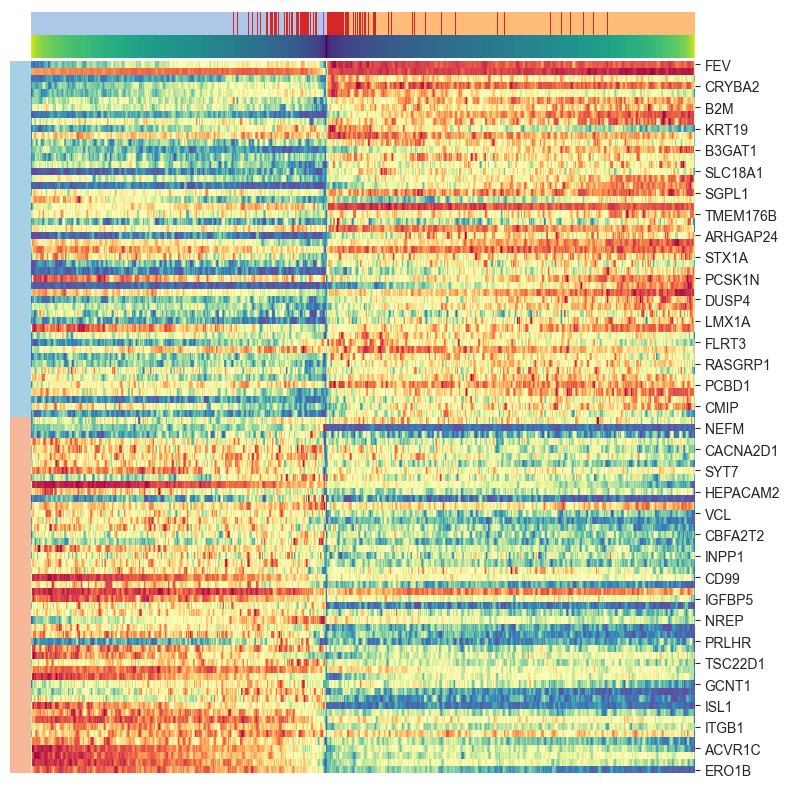

In [1432]:

cm, df = bifurcation_heatmap(endo_adata,  diff_df.names[:50].tolist() + diff_df.names[-50:].tolist(),
                    bifurcate_key='future_cell_type',
    b_pool=['sc_beta', 'sc_ec'],
    sortby="pseudotime", col_color=[cell_type_key, 'pseudotime'], col_cluster=False, row_cluster=False,
                   color_map='Spectral_r',figsize=(8, 8), sort=False, show=False)

#### GRN analysis

In [278]:
grn_fitter = pygot.tl.analysis.GRN()
grn = grn_fitter.fit(endo_adata, species='human', non_negative=True, n_epoch=10000, l1_penalty=0.001)

TF number: 236, Index(['SNAI2', 'EGR2', 'GFI1', 'FOXC1', 'ARX', 'PHOX2B', 'PITX2', 'HOXB7',
       'PAX6', 'PAX4',
       ...
       'MELK', 'NANOS1', 'NEUROG3', 'PHLDA2', 'PPARGC1A', 'RUFY3', 'SLC18A1',
       'TAGLN2', 'TFF3', 'TPI1'],
      dtype='object', length=236)
scale velocity with factor : 56.77878273168605
l1_penalty: 0.001 min_beta: 1.0


Epoch [10000/10000], Train Loss: 79.6905, Val Loss: 61.0240: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:12<00:00, 75.74it/s]


In [257]:
grn.ranked_edges.loc[grn.ranked_edges.EdgeWeight > 0.1]

Gene1    Gene2 EdgeWeight absEdgeWeight
2563       FEV     TPH1   2.610013      2.610013
2557       FEV   COL5A2    2.24242       2.24242
2548       FEV    CBLN1   2.081551      2.081551
19682  NEUROG3      DDC   2.064927      2.064927
2553       FEV   ADRA2A   2.031582      2.031582
...        ...      ...        ...           ...
5212     PTF1A  C9orf24   0.129772      0.129772
5850      KLF4   IGFBP1   0.129758      0.129758
399     PHOX2B     RGS7   0.129749      0.129749
18172      SP5    THEM6   0.129746      0.129746
18391    HOXA3     RGS9   0.129742      0.129742

[10000 rows x 4 columns]

In [279]:
beta_genes = sc.get.rank_genes_groups_df(mature_endo_adata, 'sc_beta', key='rank_genes_groups_filtered', pval_cutoff=0.01, log2fc_min=1).names
beta_genes = beta_genes[~pd.isna(beta_genes)].tolist()[:50]
ec_genes = sc.get.rank_genes_groups_df(mature_endo_adata, 'sc_ec',key='rank_genes_groups_filtered', pval_cutoff=0.01, log2fc_min=1).names
ec_genes = ec_genes[~pd.isna(ec_genes)].tolist()[:50]

In [280]:
#df = grn_data.ranked_edges.loc[grn_data.ranked_edges.EdgeWeight > 0.5]
all_df = grn.ranked_edges.loc[(grn.ranked_edges.EdgeWeight > 0.2)]
beta_df = grn.ranked_edges.loc[(grn.ranked_edges.Gene2.isin(beta_genes)) & (grn.ranked_edges.EdgeWeight > 0)]
beta_master_regulator = pd.DataFrame(beta_df.groupby('Gene1').apply(lambda x: sum(x.EdgeWeight)).sort_values(ascending=False), columns=['score']).reset_index()
beta_master_regulator['score'] /= beta_master_regulator['score'].sum()
ec_df = grn.ranked_edges.loc[(grn.ranked_edges.Gene2.isin(ec_genes)) & (grn.ranked_edges.EdgeWeight > 0)]
ec_master_regulator = pd.DataFrame(ec_df.groupby('Gene1').apply(lambda x: sum(x.EdgeWeight)).sort_values(ascending=False), columns=['score']).reset_index()
ec_master_regulator['score'] /= ec_master_regulator['score'].sum()


In [281]:
prog_endo_adata.uns['future_cell_type_colors'] = np.array(['#aec7e8', '#ffbb78'])

<Axes: xlabel='score', ylabel='Gene1'>

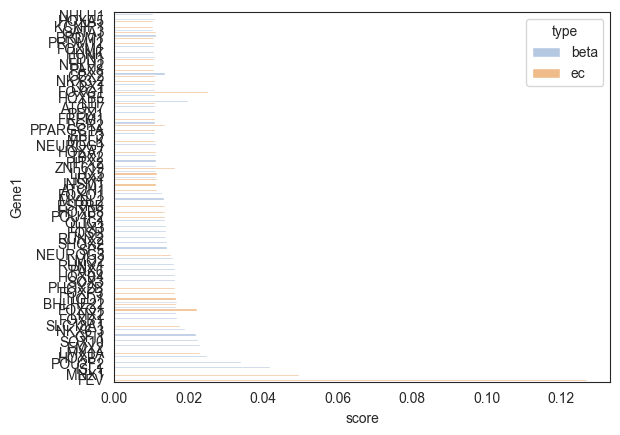

In [282]:
beta_master_regulator['type'] = 'beta'
ec_master_regulator['type'] = 'ec'
combined_master_regulator = pd.concat([beta_master_regulator, ec_master_regulator])

sns.barplot(combined_master_regulator.loc[combined_master_regulator.score > 0.01].sort_values('score'), y='Gene1', x='score', hue='type', palette=prog_endo_adata.uns['future_cell_type_colors'] )

In [88]:
ga =  pygot.tl.analysis.GraphAnalysis(grn)

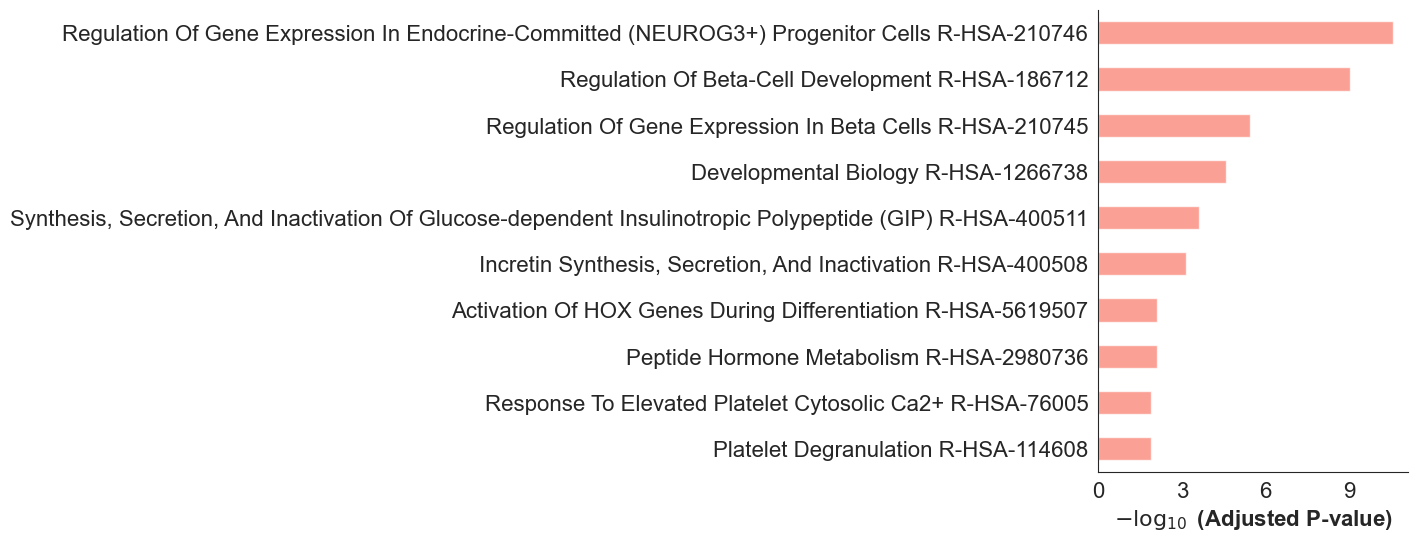

In [89]:
import gseapy as gp


enr = gp.enrichr(gene_list= combined_master_regulator.loc[combined_master_regulator.score > 0.01].sort_values('score').Gene1.unique().tolist(), 
                 gene_sets='Reactome_2022',  # 选择合适的数据库，如KEGG、GO等
                 organism='Human',            # 物种
                 
                 #outdir='enrichr_results',    # 输出结果目录
                 cutoff=0.05                  # p-value截断值
                )

ax = gp.barplot(enr.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=10,
              top_term=10,
              #figsize=(3,5),
              
              xticklabels_rot=45, # rotate xtick labels
              show_ring=True, # set to False to revmove outer ring
              marker='o',
             )

#### in silico perturb

In [90]:
import celloracle as co

In [91]:
import magic

mag = magic.MAGIC()
X_magic = mag.fit_transform(endo_adata)
endo_adata.layers['X_magic'] = X_magic.X

Calculating MAGIC...
  Running MAGIC on 9153 cells and 1948 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.19 seconds.
    Calculating KNN search...
    Calculated KNN search in 11.37 seconds.
    Calculating affinities...
    Calculated affinities in 10.60 seconds.
  Calculated graph and diffusion operator in 25.20 seconds.
  Calculating imputation...
  Calculated imputation in 1.54 seconds.
Calculated MAGIC in 26.81 seconds.


In [278]:
endo_adata.layers['spliced'] = endo_adata.X
endo_adata.layers['unspliced'] = endo_adata.X
sc.pp.neighbors(endo_adata, n_pcs=10)
scv.pp.moments(endo_adata, n_pcs=10, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [92]:
endo_adata.layers['raw_count'] = endo_adata.X
#endo_adata.layers['imputed_count'] = endo_adata.X
endo_adata.layers['imputed_count'] = endo_adata.layers['X_magic']

In [93]:
oracle_adata = endo_adata.copy()

Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing velocity embedding
    finished (0:00:02) --> added
    'velocity_emb', embedded velocity vectors (adata.obsm)


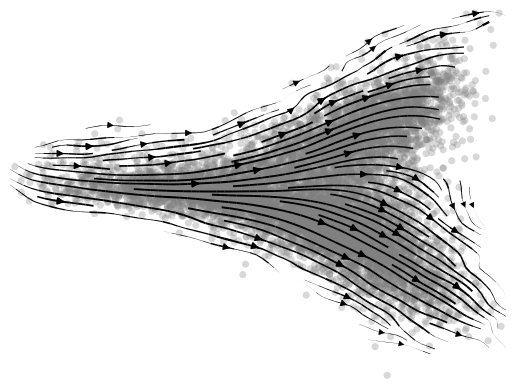

In [94]:
sc.pp.neighbors(oracle_adata)
pygot.tl.traj.velocity_graph(oracle_adata, embedding_key='X_pca', velocity_key='velocity_pca')
scv.pl.velocity_embedding_stream(oracle_adata, basis='emb')

Device: cuda


Density Loss 0.0000, Corr 0.0000 Satisfied 100.000000%: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.84it/s]


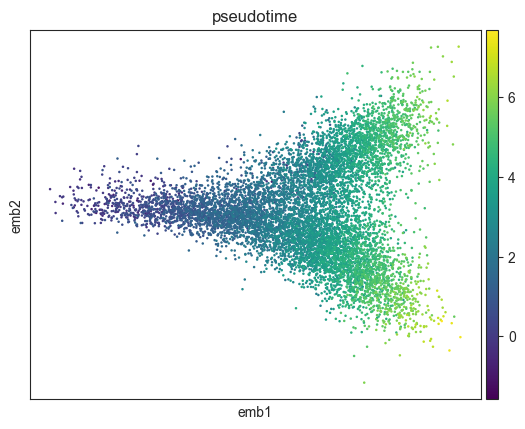

In [95]:
pm = pygot.tl.analysis.ProbabilityModel()
pm.fit(oracle_adata, embedding_key='X_pca', velocity_key='velocity_pca', marginal=False)
oracle_adata.obs['pseudotime'] = pm.estimate_pseudotime(oracle_adata)
sc.pl.embedding(oracle_adata, color='pseudotime', basis='emb')

In [723]:
oracle = co.Oracle()
oracle.import_anndata_as_normalized_count(oracle_adata, cluster_column_name=cell_type_key, embedding_name='X_emb')

In [945]:
grn.export_grn_into_celloracle(oracle)

Finish!


In [1458]:
beta_cell_idx = np.where(oracle.adata.obs['future_cell_type'] == 'sc_beta')[0]
ec_cell_idx = np.where(oracle.adata.obs['future_cell_type'] == 'sc_ec')[0]
cell_idx_list = [beta_cell_idx, ec_cell_idx]

In [1215]:
candidate_TF = grn.tf_names
scores = []
perturb_df = []
for tf in tqdm(candidate_TF):
    oracle.simulate_shift(perturb_condition={tf: 0.0},
                      n_propagation=3)
    oracle.adata.obs['score'] = np.sum(oracle.adata.layers['delta_X'] * oracle.adata.layers['velocity'], axis=1)
    perturb_df.append(oracle.adata.obs['score'].copy())
    s = oracle.adata.obs.loc[oracle.adata.obs.index[beta_cell_idx]]['score'].mean() - oracle.adata.obs.loc[oracle.adata.obs.index[ec_cell_idx]]['score'].mean()
    scores.append(s)
screen_res = pd.DataFrame(scores, index=candidate_TF, columns=['score']).reset_index()
screen_res['absscore'] = abs(screen_res['score'])
screen_res

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [37:42<00:00,  9.59s/it]


index      score   absscore
0      SNAI2  -4.973134   4.973134
1       EGR2   0.255505   0.255505
2       GFI1   1.337356   1.337356
3      FOXC1   3.828671   3.828671
4        ARX  -3.537188   3.537188
..       ...        ...        ...
231    RUFY3   0.663204   0.663204
232  SLC18A1  19.478974  19.478974
233   TAGLN2  11.759865  11.759865
234     TFF3  -2.636966   2.636966
235     TPI1  13.147704  13.147704

[236 rows x 3 columns]

In [1220]:
perturb_df = pd.DataFrame(perturb_df, index=candidate_TF).T

In [1455]:
perturb_values = perturb_df.values
perturb_values[perturb_values > 0] = np.log(1+perturb_values[perturb_values > 0] )
perturb_values[perturb_values < 0] = -np.log(1-perturb_values[perturb_values < 0] )
perturb_df2 = pd.DataFrame(perturb_values, index=perturb_df.index, columns=perturb_df.columns)

In [1457]:
perturb_df2

SNAI2      EGR2      GFI1     FOXC1       ARX  \
library.barcode                                                              
stg5diff2_S5d2_b2.bcGLRE -1.473376 -2.993157 -2.226052 -2.490446 -3.291613   
stg5diff1_S5d2_b2.bcGQUX -2.475561 -4.000489 -3.948680 -3.008360 -3.994103   
stg5diff1_S5d2_b2.bcICPS -2.785363 -3.502698 -2.757105 -2.259203 -3.468533   
stg5diff2_S5d2_b2.bcDQTI -1.341849 -1.981880 -0.720324 -2.117711 -3.152042   
stg5diff1_S5d2_b2.bcCTCV -2.533523 -3.876260 -3.811903 -2.952899 -4.331680   
...                            ...       ...       ...       ...       ...   
stg5diff1_S5d7_b2.bcGXOA -1.261597 -0.053286  0.000000 -1.804934 -1.390417   
stg5diff1_S5d7_b2.bcFAML -1.801469 -1.139742 -2.653804 -2.436677 -2.463378   
stg5diff2_S5d7_b2.bcEEZC -2.448367 -2.109174 -0.475031 -2.750044 -2.273644   
stg5diff2_S5d7_b2.bcDJDX -2.181519 -1.098339 -1.957419 -2.442467 -2.581323   
stg5diff1_S5d7_b2.bcGPOX -2.109082 -0.125130  0.000000 -1.100891 -2.163373   

                            PHOX2B     PITX2     HOXB7      PAX6      PAX4  \
library.barcode                                                              
stg5diff2_S5d2_b2.bcGLRE -1.483436 -3.411823 -2.157400 -3.078882 -2.656471   
stg5diff1_S5d2_b2.bcGQUX -2.478084 -3.678179 -4.064931 -4.441192 -3.149346   
stg5diff1_S5d2_b2.bcICPS -0.779512 -3.590022 -3.477686 -3.368431 -2.676377   
stg5diff2_S5d2_b2.bcDQTI -2.219771 -1.425530 -1.539254 -2.587418 -2.556777   
stg5diff1_S5d2_b2.bcCTCV -2.762872 -4.132243 -3.848553 -3.644904 -3.004155   
...                            ...       ...       ...       ...       ...   
stg5diff1_S5d7_b2.bcGXOA -1.880157 -0.129292 -0.350798 -1.690225 -1.951427   
stg5diff1_S5d7_b2.bcFAML -1.841887 -1.910346 -1.596454 -2.317950 -2.645738   
stg5diff2_S5d7_b2.bcEEZC -1.796929 -0.663433 -1.999311 -3.378445 -1.798930   
stg5diff2_S5d7_b2.bcDJDX -2.256473 -1.568092 -1.432919 -2.133374 -2.581609   
stg5diff1_S5d7_b2.bcGPOX -2.128345 -0.539712 -0.478861 -2.762154 -1.312362   

                          ...      MELK    NANOS1   NEUROG3    PHLDA2  \
library.barcode           ...                                           
stg5diff2_S5d2_b2.bcGLRE  ... -2.086398 -3.011036 -4.241476 -1.458955   
stg5diff1_S5d2_b2.bcGQUX  ... -3.012486 -4.042614 -4.679193 -3.570642   
stg5diff1_S5d2_b2.bcICPS  ... -2.643183 -3.143731 -4.448360 -2.373441   
stg5diff2_S5d2_b2.bcDQTI  ... -1.615496 -2.486973 -4.082626 -1.554513   
stg5diff1_S5d2_b2.bcCTCV  ... -2.947695 -3.501684 -4.762528 -3.411143   
...                       ...       ...       ...       ...       ...   
stg5diff1_S5d7_b2.bcGXOA  ... -0.117499 -1.316789 -2.777549 -1.970430   
stg5diff1_S5d7_b2.bcFAML  ... -2.020328 -1.997084 -3.480241 -3.150427   
stg5diff2_S5d7_b2.bcEEZC  ... -1.639783 -2.162788 -2.980856 -2.510183   
stg5diff2_S5d7_b2.bcDJDX  ... -1.604836 -2.244655 -3.482733 -2.793784   
stg5diff1_S5d7_b2.bcGPOX  ... -0.845337 -1.710986 -1.915284 -1.210260   

                          PPARGC1A     RUFY3   SLC18A1    TAGLN2      TFF3  \
library.barcode                                                              
stg5diff2_S5d2_b2.bcGLRE -0.209650 -0.185952 -1.664047 -3.077818 -1.882089   
stg5diff1_S5d2_b2.bcGQUX -1.755440 -0.897049 -2.882156 -3.837179 -3.529704   
stg5diff1_S5d2_b2.bcICPS -0.113530 -0.328588 -2.009223 -3.336095 -2.443029   
stg5diff2_S5d2_b2.bcDQTI  0.000000 -0.095935 -1.234471 -2.836010 -1.461455   
stg5diff1_S5d2_b2.bcCTCV -0.717968 -0.548664 -2.386227 -3.843203 -3.429145   
...                            ...       ...       ...       ...       ...   
stg5diff1_S5d7_b2.bcGXOA  0.000000 -0.336656 -1.391092 -2.731696 -1.306643   
stg5diff1_S5d7_b2.bcFAML -1.748300 -1.052126 -3.600432 -3.945760 -2.709925   
stg5diff2_S5d7_b2.bcEEZC -0.766270 -0.508681 -1.757133 -2.909989 -2.629534   
stg5diff2_S5d7_b2.bcDJDX -2.010276 -0.979086 -3.508237 -3.775551 -2.698372   
stg5diff1_S5d7_b2.bcGPOX  0.000000 -0.188376 -0.465009 -2.264164 -2.044286   

                              TPI1

In [1492]:
(perturb_df2.loc[oracle_adata.obs.index[beta_cell_idx]].mean(axis=0) - perturb_df2.loc[oracle_adata.obs.index[ec_cell_idx]].mean(axis=0)).sort_values()

BNC2      -1.630266
FOXO1     -1.378649
PBX3      -1.242317
POU3F1    -1.242292
ISL1      -1.176397
             ...   
SP5        1.292207
NR0B1      1.295847
LMX1A      1.315469
PAX1       1.328821
SLC18A1    1.492070
Length: 236, dtype: float64

In [1493]:
screen_res2 = pd.DataFrame((perturb_df2.loc[oracle_adata.obs.index[beta_cell_idx]].mean(axis=0) - perturb_df2.loc[oracle_adata.obs.index[ec_cell_idx]].mean(axis=0)).sort_values(), columns=['score'])
screen_res2['absscore'] = abs(screen_res2['score'])
screen_res2 = screen_res2.reset_index()

<Axes: xlabel='score', ylabel='index'>

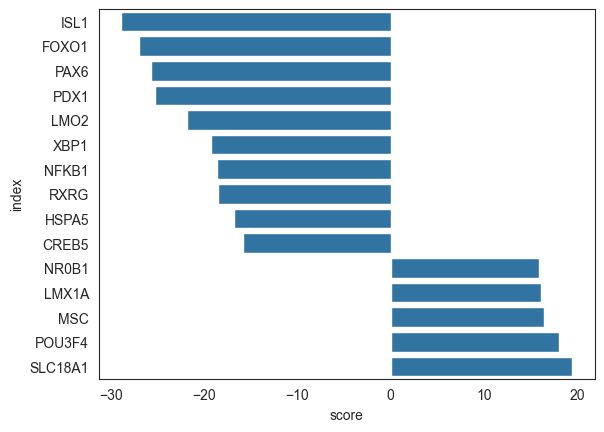

In [285]:

sns.barplot(screen_res.sort_values('absscore', ascending=False).head(15).sort_values('score'), y='index', x='score',)

In [1240]:
screen_res.sort_values('absscore')

index      score   absscore
218  HMGB1  -0.010243   0.010243
66    GBX2   0.021312   0.021312
198   SMC3  -0.028589   0.028589
124   ETS2  -0.044270   0.044270
193    ID4  -0.057088   0.057088
..     ...        ...        ...
210   LMO2 -21.826428  21.826428
62    PDX1 -25.261206  25.261206
8     PAX6 -25.760435  25.760435
52   FOXO1 -27.030296  27.030296
128   ISL1 -28.934140  28.934140

[236 rows x 3 columns]

<Axes: title={'center': 'inhibit'}, xlabel='emb1', ylabel='emb2'>

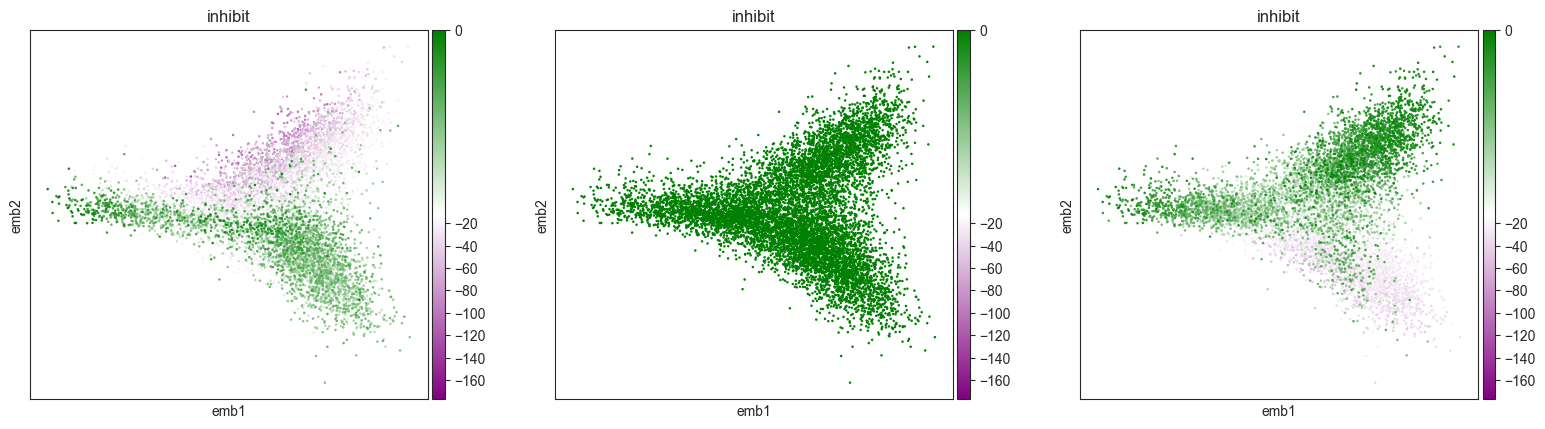

In [1244]:
import matplotlib.colors as mcolors
colors = ["purple", "white", "green"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)

# 定义归一化，使得 0 为中间值
norm = mcolors.TwoSlopeNorm(vmin=perturb_df.values.flatten().min(), vcenter=perturb_df.mean().mean(), vmax=0)

fig, axes = plt.subplots(1,3, figsize=(6.4*3, 4.8))
tf = 'ISL1'
oracle.simulate_shift(perturb_condition={tf: 0.0},
                      n_propagation=3)
oracle.adata.obs['inhibit'] = np.sum(oracle.adata.layers['delta_X'] * oracle.adata.layers['velocity'], axis=1)
sc.pl.embedding(oracle.adata, color='inhibit', basis='emb', cmap=custom_cmap, norm=norm, ax=axes[0], show=False)

tf = 'HMGB1'
oracle.simulate_shift(perturb_condition={tf: 0.0},
                      n_propagation=3)
oracle.adata.obs['inhibit'] = np.sum(oracle.adata.layers['delta_X'] * oracle.adata.layers['velocity'], axis=1)
sc.pl.embedding(oracle.adata, color='inhibit', basis='emb', cmap=custom_cmap, norm=norm, ax=axes[1], show=False)

tf = 'SLC18A1'
oracle.simulate_shift(perturb_condition={tf: 0.0},
                      n_propagation=3)
oracle.adata.obs['inhibit'] = np.sum(oracle.adata.layers['delta_X'] * oracle.adata.layers['velocity'], axis=1)
sc.pl.embedding(oracle.adata, color='inhibit', basis='emb', cmap=custom_cmap, norm=norm, ax=axes[2], show=False)


In [1301]:
torch.save(grn, '/storage/xuruihong/repository/pygot_data/beta_diff/beta_ec_grn.pkl')

#### Additonal Data

##### Integrate data

... storing 'batch' as categorical
... storing 'celltype' as categorical


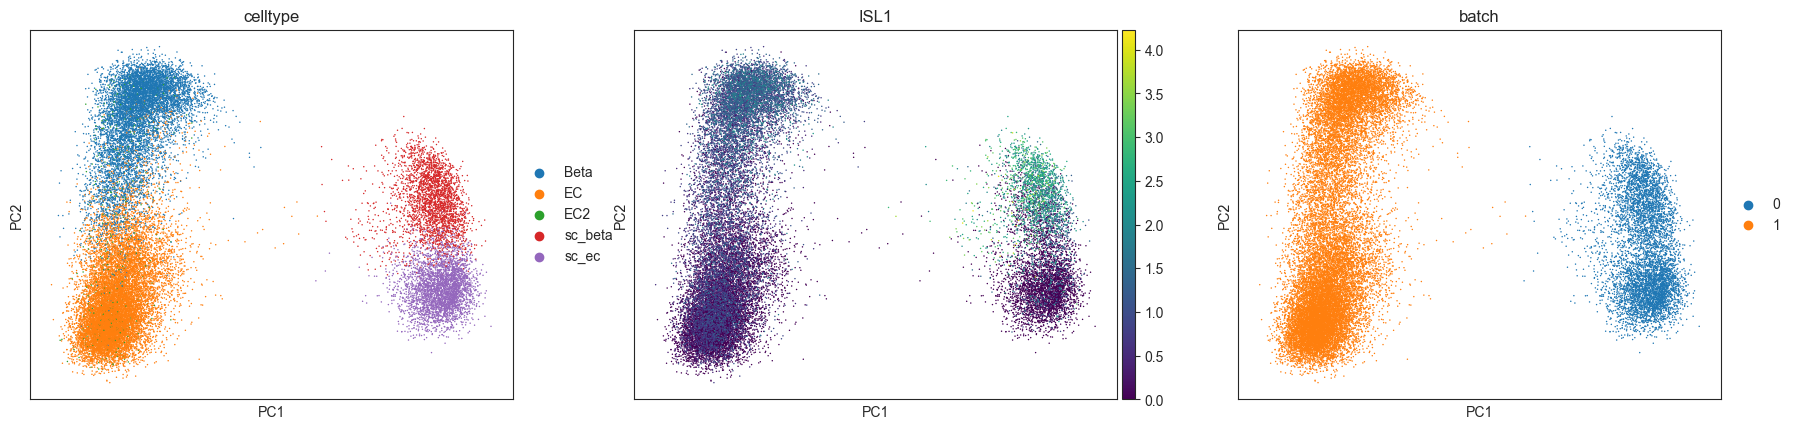

In [804]:
adata_stage6 = sc.read('../pygot_data/beta_diff/multi_omics/integratedRNA.h5ad')
adata_stage5 = sc.AnnData(endo_adata.layers['raw'], obs=endo_adata.obs, var=endo_adata.var)
adata_stage5.obs['batch'] = '0'
adata_stage5.obs['celltype'] = adata_stage5.obs['Assigned_cluster']
adata_stage5 = adata_stage5[adata_stage5.obs['celltype'].isin(['sc_beta', 'sc_ec'])]

adata_stage6.obs['batch'] = '1'
integrated_adata = sc.concat([adata_stage5, adata_stage6])
integrated_adata.layers['counts'] = integrated_adata.X.copy()

integrated_adata.obs['celltype'] = integrated_adata.obs['celltype'].astype(str)
integrated_adata = integrated_adata[integrated_adata.obs['celltype'].isin( ['sc_beta', 'sc_ec', 'Beta', 'EC', 'EC2'])]

sc.pp.normalize_total(integrated_adata)
sc.pp.log1p(integrated_adata)
sc.tl.pca(integrated_adata)
sc.pp.neighbors(integrated_adata, use_rep='X_pca')
sc.tl.umap(integrated_adata)

sc.pl.pca(integrated_adata, color=['celltype','ISL1', 'batch'])

<Axes: title={'center': 'celltype'}, xlabel='PC1', ylabel='PC2'>

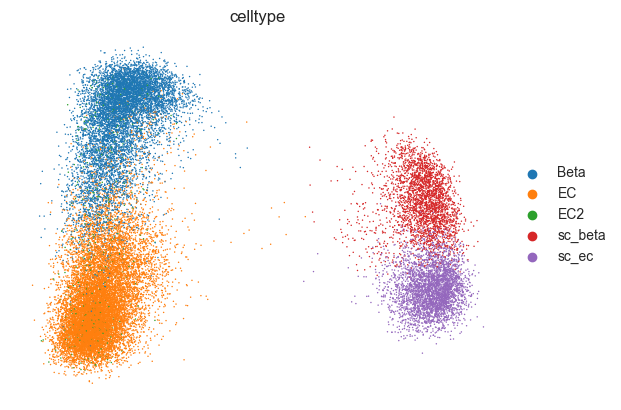

In [1361]:
sc.pl.pca(integrated_adata, color=['celltype'], frameon=False, show=False)


In [1320]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
X = integrated_adata[integrated_adata.obs['batch'] == '0'].X.toarray()
X = scaler.fit_transform(X)
y = integrated_adata[integrated_adata.obs['batch'] == '0'].obs['celltype'].replace({'sc_beta':0, 'sc_ec':1}).to_numpy()
clf = RandomForestClassifier()
clf.fit(X, y)

RandomForestClassifier()

In [1362]:
cm

Beta     EC
Beta  7288   1066
EC     490  12439

In [1332]:
X = integrated_adata[integrated_adata.obs['batch'] == '1'].X.toarray()
X = scaler.fit_transform(X)
y_ood = integrated_adata[integrated_adata.obs['batch'] == '1'].obs['celltype'].replace({'Beta':0, 'EC':1, 'EC2':1}).to_numpy()
y_pred = clf.predict(X)

In [1363]:
clf.score(X, y_ood)

0.9268900061081614

Text(50.722222222222214, 0.5, 'Cell Type')

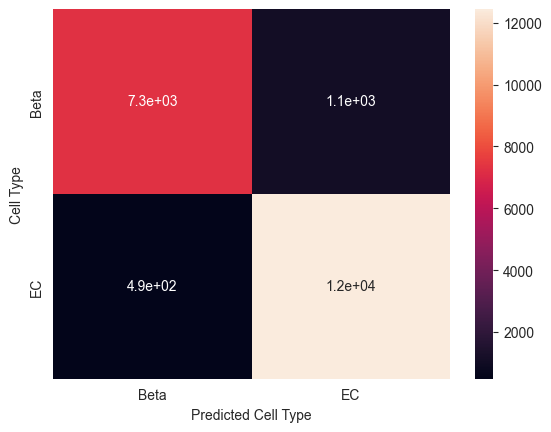

In [1356]:
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(y_pred, y_ood), index=['Beta', 'EC'], columns=['Beta', 'EC'])
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted Cell Type')
plt.ylabel('Cell Type')


#### multi-omics figR vs GOT + celloracle

In [1040]:
figR_GRN = pd.read_csv('../pygot_data/beta_diff/multi_omics/FigR_GRN.txt', sep='\t')
figR_GRN

DORC    Motif  Enrichment.Z  Enrichment.P  Enrichment.log10P  \
1       ADAMTS2      AHR     -1.120584      0.262465          -0.580929   
2       ADAMTS2     AIRE     -0.858335      0.390708          -0.408148   
3       ADAMTS2     ALX1     -0.760794      0.446780          -0.349906   
4       ADAMTS2     ALX3      1.034086      0.301096           0.521295   
5       ADAMTS2     ALX4      1.034086      0.301096           0.521295   
...         ...      ...           ...           ...                ...   
285116   ZNF706  ZSCAN30     -1.386130      0.165707          -0.780659   
285117   ZNF706  ZSCAN31     -0.570548      0.568306          -0.245418   
285118   ZNF706   ZSCAN4     -1.055183      0.291342          -0.535598   
285119   ZNF706  ZSCAN5C     -1.105903      0.268768          -0.570622   
285120   ZNF706   ZSCAN9      0.011210      0.991056           0.003902   

            Corr    Corr.Z    Corr.P  Corr.log10P     Score  
1       0.150799  1.376830  0.168565     0.773233  0.000000  
2       0.050083  0.481731  0.629997     0.200661  0.000000  
3      -0.369603 -3.248195  0.001161    -2.935020  0.000000  
4       0.015454  0.173966  0.861892     0.064547  0.044084  
5      -0.075282 -0.632445  0.527096    -0.278110 -0.174259  
...          ...       ...       ...          ...       ...  
285116 -0.051937 -0.939510  0.347469    -0.459084  0.000000  
285117 -0.030237 -0.504329  0.614030    -0.211810  0.000000  
285118  0.008099  0.264490  0.791402     0.101603  0.000000  
285119  0.003732  0.176925  0.859567     0.065720  0.000000  
285120 -0.092698 -1.756954  0.078926    -1.102782 -0.003593  

[285120 rows x 10 columns]

In [933]:
gene_with_motif = figR_GRN.Motif.unique()

In [1041]:
#figR_GRN = figR_GRN.loc[abs(figR_GRN.Score) > 0.5]
figR_GRN = figR_GRN.loc[(figR_GRN['Enrichment.P'] < 0.05) & (abs(figR_GRN.Score) > 0.5)]
figR_GRN

DORC   Motif  Enrichment.Z  Enrichment.P  Enrichment.log10P  \
51      ADAMTS2   CEBPE      2.115212      0.034412           1.463292   
63      ADAMTS2   CREB5      2.974123      0.002938           2.531909   
66      ADAMTS2    CREM      2.594106      0.009484           2.023021   
84      ADAMTS2    DLX6      2.994462      0.002749           2.560780   
300     ADAMTS2    ISL1      3.272822      0.001065           2.972733   
...         ...     ...           ...           ...                ...   
284435   ZNF706  MLXIPL      2.106885      0.035128           1.454352   
284458   ZNF706    MZF1      2.457403      0.013995           1.854040   
284637   ZNF706   SMAD3      2.335155      0.019535           1.709179   
284690   ZNF706   TBPL2      1.997969      0.045720           1.339894   
284771   ZNF706  ZBTB12      2.143373      0.032083           1.493723   

            Corr    Corr.Z    Corr.P  Corr.log10P     Score  
51      0.124506  1.143152  0.252975     0.596922  0.554891  
63      0.238591  2.157073  0.031000     1.508639  1.470478  
66      0.169213  1.540486  0.123442     0.908537  0.880233  
84     -0.120190 -1.031562  0.302277    -0.519594 -0.516847  
300     0.348306  3.132162  0.001735     2.760641  2.553123  
...          ...       ...       ...          ...       ...  
284435 -0.146191 -2.829733  0.004659    -2.331737 -1.402057  
284458 -0.114587 -2.195927  0.028097    -1.551338 -1.379879  
284637  0.124120  2.591252  0.009563     2.019418  1.538933  
284690  0.052993  1.164833  0.244087     0.612456  0.554945  
284771 -0.061660 -1.134502  0.256584    -0.590771 -0.552168  

[2360 rows x 10 columns]

In [129]:
figR_adata =  sc.read('../pygot_data/beta_diff/multi_omics/integratedRNA.h5ad')
sc.pp.normalize_total(figR_adata)
sc.pp.log1p(figR_adata)
figR_adata = figR_adata[figR_adata.obs['celltype'].isin( [ 'Beta', 'EC'])]
sc.tl.rank_genes_groups(figR_adata, groupby='celltype')


In [350]:
figR_diff_df = sc.get.rank_genes_groups_df(figR_adata, 'EC').set_index('names')
figR_diff_df['weight'] = figR_diff_df['scores'].apply(lambda x: np.log(x+1) if x > 0 else -np.log(-x+1))


In [351]:
factor = abs(figR_diff_df.loc[figR_diff_df.weight >0].weight.sum() / figR_diff_df.loc[figR_diff_df.weight <0].weight.sum())
figR_diff_df.loc[figR_diff_df.weight >0, 'weight'] = figR_diff_df.loc[figR_diff_df.weight >0, 'weight'] / factor


In [1042]:
bias_TF = figR_GRN.groupby('Motif').apply(lambda x: (figR_diff_df.loc[x.DORC]['weight'].to_numpy() * x.Score.to_numpy() ).sum() )
bias_TF = pd.DataFrame(bias_TF.sort_values(), columns=['bias'])
bias_TF = bias_TF.loc[bias_TF.index.intersection(grn.ranked_edges.Gene1.unique())]
bias_TF['absscore'] = abs(bias_TF['bias'])
bias_TF = bias_TF.reset_index()
from sklearn.preprocessing import maxabs_scale
bias_TF['gene'] = bias_TF['Motif']
bias_TF['norm_score'] = maxabs_scale(bias_TF['bias'].apply(lambda x: np.log(x+1) if x > 0 else -np.log(-x+1)))
bias_TF['method'] = 'figR'

In [1504]:
screen_res = screen_res.rename({'index':'gene'}, axis=1)
diff_ns_df = screen_res


In [1505]:
#diff_ns_df['norm_score'] = maxabs_scale(diff_ns_df['score'].apply(lambda x: np.log(x+1) if x > 0 else -np.log(-x+1)))
diff_ns_df['norm_score'] = maxabs_scale(diff_ns_df['score'])
diff_ns_df['method'] = 'GOT'

In [1506]:
final_res = pd.concat([bias_TF[['gene', 'norm_score', 'method']], diff_ns_df[['gene', 'norm_score', 'method']]])

In [1507]:
motif_genes = final_res.groupby('gene').apply(lambda x: len(x) > 1)
motif_genes = motif_genes.index[motif_genes]

In [1508]:
#_, endo_var = sc.pp.calculate_qc_metrics(endo_adata)
#_, figR_var = sc.pp.calculate_qc_metrics(figR_adata)
motif_genes = motif_genes[(endo_var.loc[motif_genes]['pct_dropout_by_counts'] < 98) & (figR_var.loc[motif_genes]['pct_dropout_by_counts'] < 99.9)] 

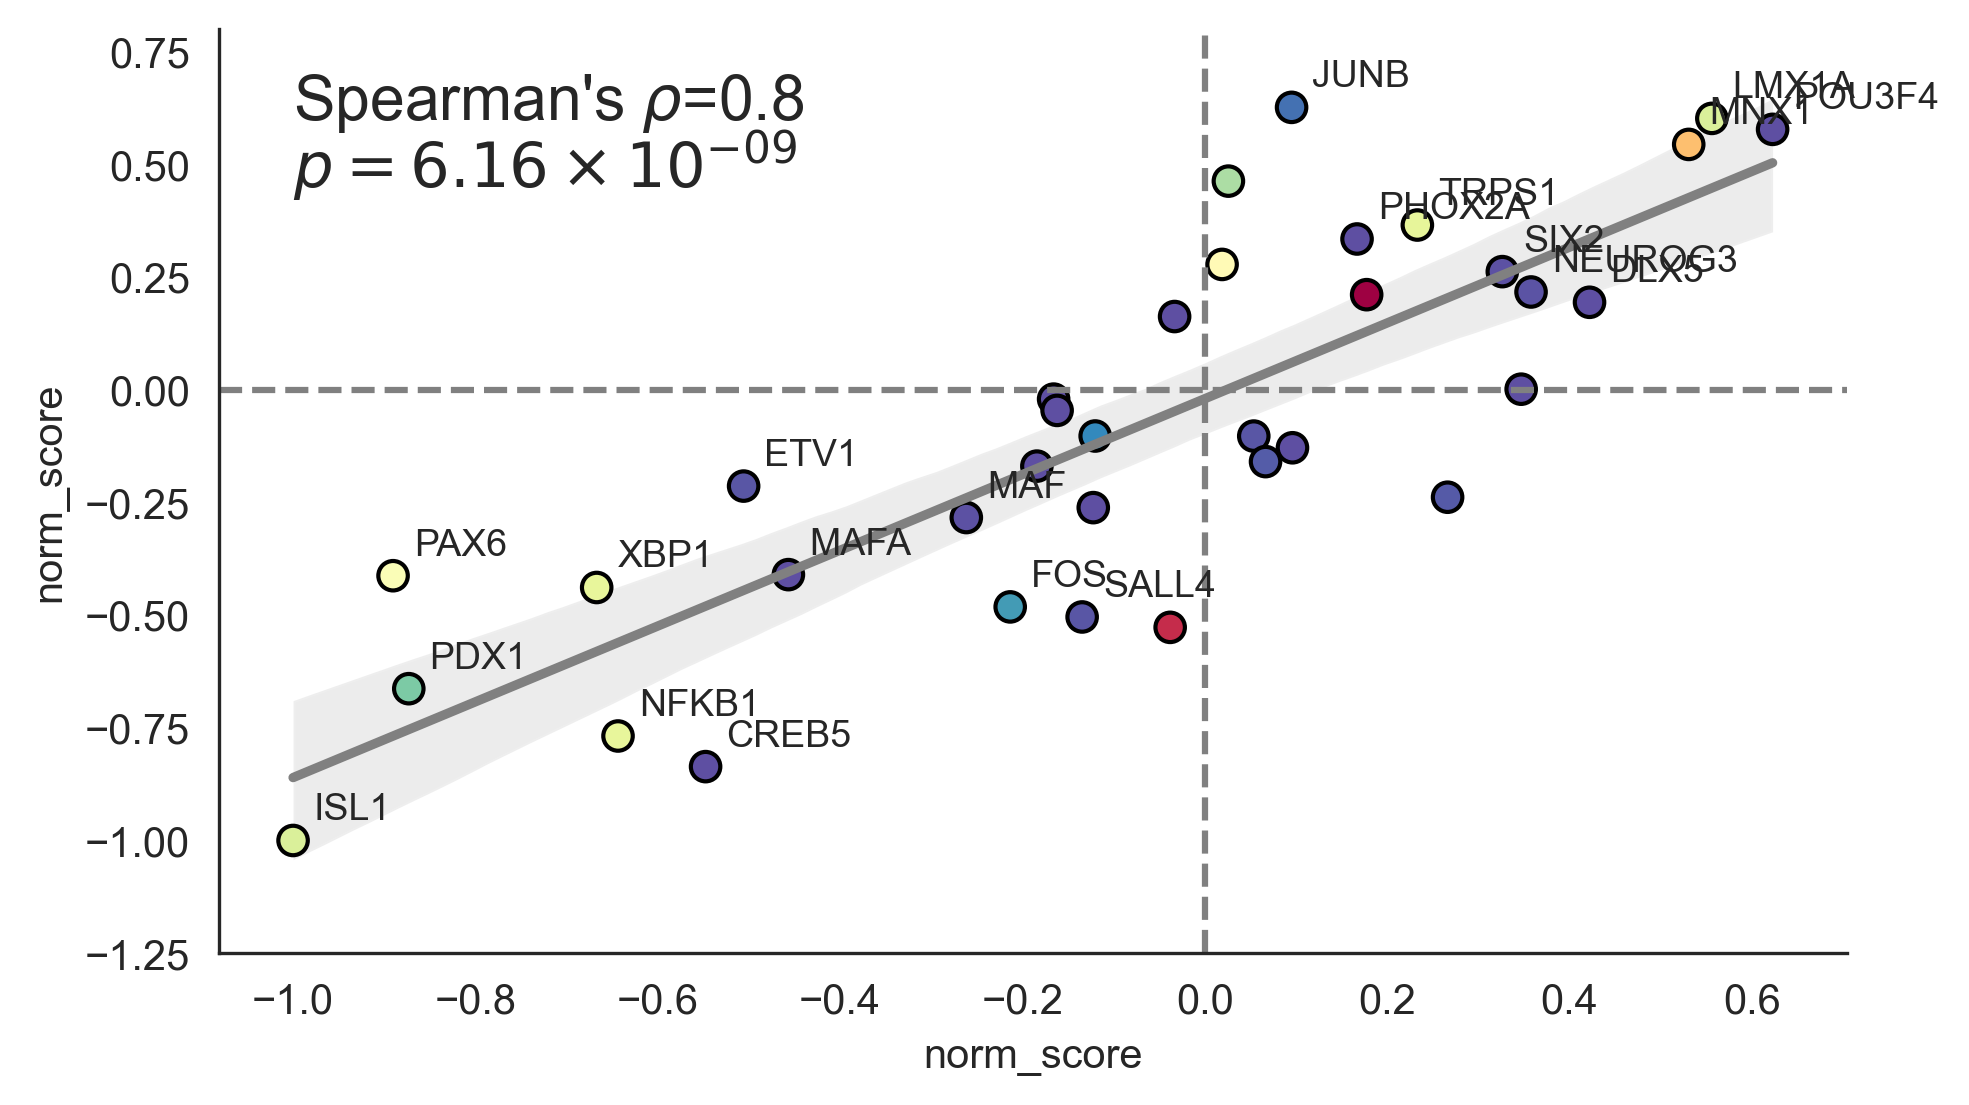

In [1509]:
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from adjustText import adjust_text  
import matplotlib.colors as mcolors
diff_gene = (figR_var.loc[motif_genes].log1p_mean_counts) * (endo_var.loc[motif_genes].log1p_mean_counts)


tmp_df = final_res.loc[final_res.gene.isin(motif_genes)]
x = tmp_df.loc[tmp_df.method == 'GOT'].set_index('gene').loc[motif_genes].norm_score
y = tmp_df.loc[tmp_df.method == 'figR'].set_index('gene').loc[motif_genes].norm_score

fig, ax = plt.subplots(1, 1, dpi=300, figsize=(7, 4))

rho, pval = spearmanr(x, y)
plt.xlabel('GOT+CellOracle Perturb Score')
plt.ylabel('figR Regulatory Bias Score')
ax.text(np.min(x), 0.6, r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
ax.text(np.min(x), 0.45, r'$p={}\times 10^{}$'.format(*r'{:.2e}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)

annotated_genes = (x*y).sort_values()[-20:]

for gene in annotated_genes.index:
    if gene in x.index and gene in y.index:
        ax.annotate(gene, 
                    xy=(x.loc[gene], y.loc[gene]), 
                    xytext=(5, 5),  
                    textcoords="offset points",
                    ha='left',
                    fontsize=9)

plt.axvline(0, linestyle='--', color='grey')
plt.axhline(0, linestyle='--', color='grey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


sns.regplot(x=x, y=y, ax=ax, scatter=False, color='grey')

scatter = ax.scatter(x, y, c=diff_gene, cmap='Spectral_r', s=50, edgecolor='k')

#cbar = fig.colorbar(scatter, ax=ax)
#cbar.set_label('Expression Level')

plt.ylim(-1.25,0.8)
plt.show()


In [1510]:
filtered_ns_df = diff_ns_df.loc[diff_ns_df.gene.isin(endo_var.loc[endo_var['pct_dropout_by_counts'] < 98].index)]

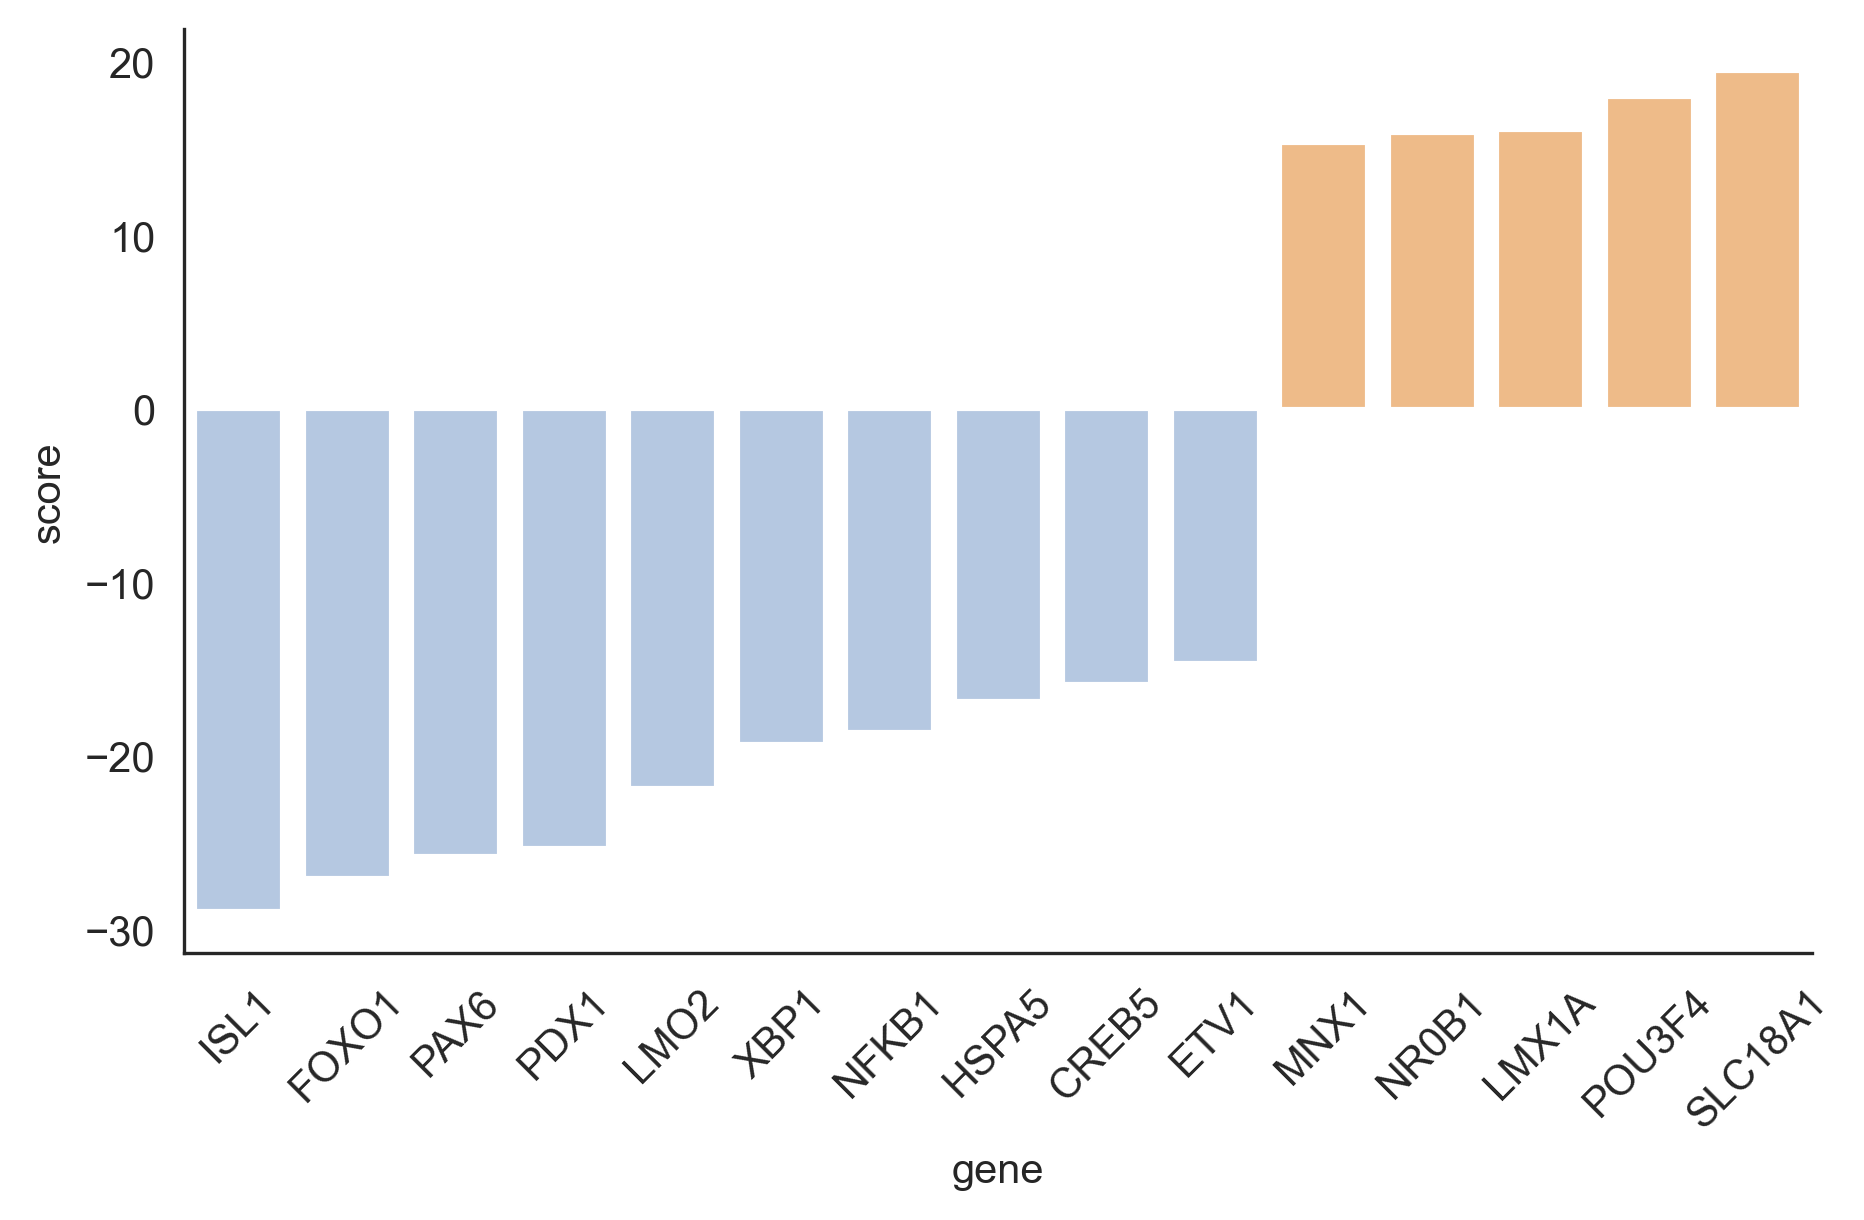

In [1511]:
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(7, 4))
plot_df = filtered_ns_df.sort_values('absscore', ascending=False).head(15).sort_values('score')
plot_df['Color'] = np.where(plot_df['score'] > 0,  '#ffbb78', '#aec7e8')
sns.barplot(plot_df, x='gene', 
            y='score',palette=plot_df['Color'].tolist(), ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(rotation=45)
plt.show()


<Axes: title={'center': 'MAFA'}, xlabel='UMAP1', ylabel='UMAP2'>

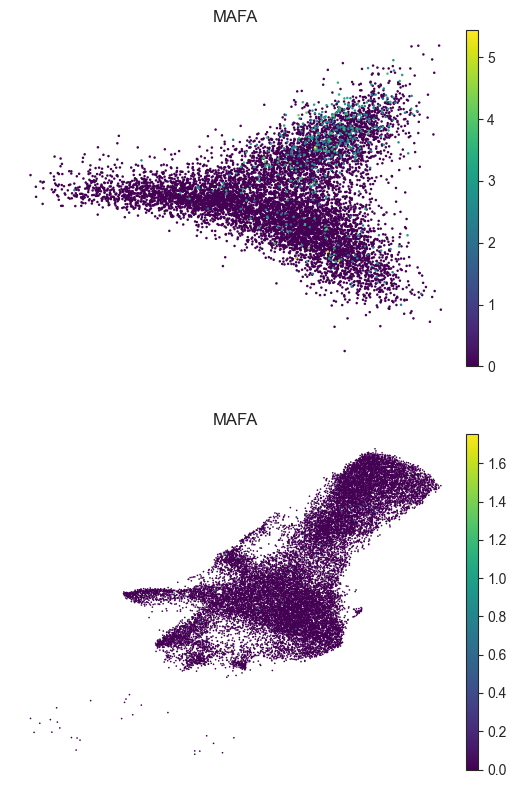

In [1512]:
fig, ax = plt.subplots(2, 1, figsize=(6.4, 4.8*2))
sc.pl.embedding(endo_adata, color='MAFA', basis='emb', ax=ax[0], show=False, frameon=False)
sc.pl.embedding(figR_adata, color='MAFA', basis='umap', ax=ax[1], show=False, frameon=False)


In [1450]:
endo_diff_df['idx'] = range(len(endo_diff_df))

In [1454]:
len(endo_diff_df) - endo_diff_df.loc['MAFA']['idx']

162.0

In [1451]:
endo_diff_df.loc['POU3F4']

scores              3.710739
logfoldchanges      3.885961
pvals               0.000207
pvals_adj           0.000777
idx               272.000000
Name: POU3F4, dtype: float64

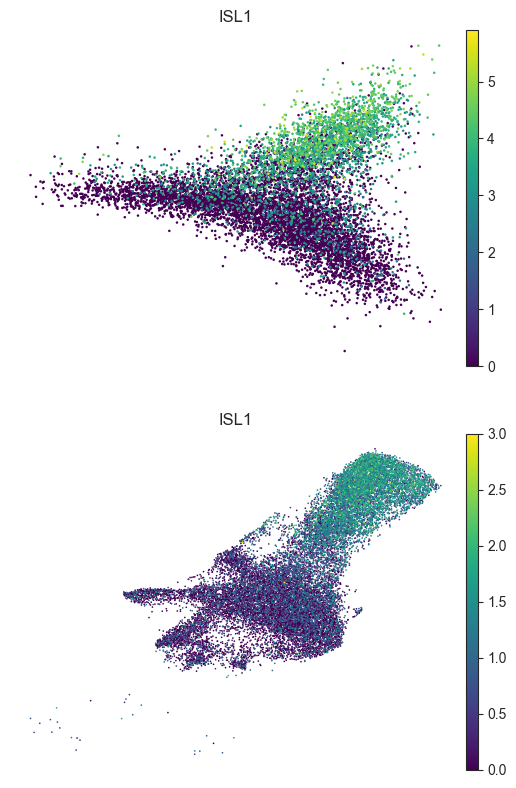

In [1519]:
fig, ax = plt.subplots(2, 1, figsize=(6.4, 4.8*2))
sc.pl.embedding(endo_adata, color='ISL1', basis='emb', ax=ax[0], show=False, frameon=False)
sc.pl.embedding(figR_adata, color='ISL1', basis='umap', ax=ax[1], show=False, frameon=False)


In [1191]:

sub_GRN = figR_GRN.loc[figR_GRN.Motif.isin(annotated_genes.index)]
target_genes = sub_GRN.DORC.unique()
regulatory_genes = sub_GRN.Motif.unique()

sub_GRN['edge'] = sub_GRN.apply(lambda x: x.Motif + '->' + x.DORC, axis=1)
sub_GRN = sub_GRN.set_index('edge')
sub_G = np.zeros(shape = (len(target_genes), len(regulatory_genes)))

for i, g1 in enumerate(regulatory_genes):
    for j, g2 in enumerate(target_genes):
        if g1+'->'+g2 in sub_GRN.index:
            sub_G[j, i] = sub_GRN.loc[g1+'->'+g2].Score

In [1192]:
row_values = figR_diff_df.loc[target_genes].scores.to_numpy()
row_colors = np.array(['green'] * len(target_genes))
row_colors[row_values > 0] = 'blue'

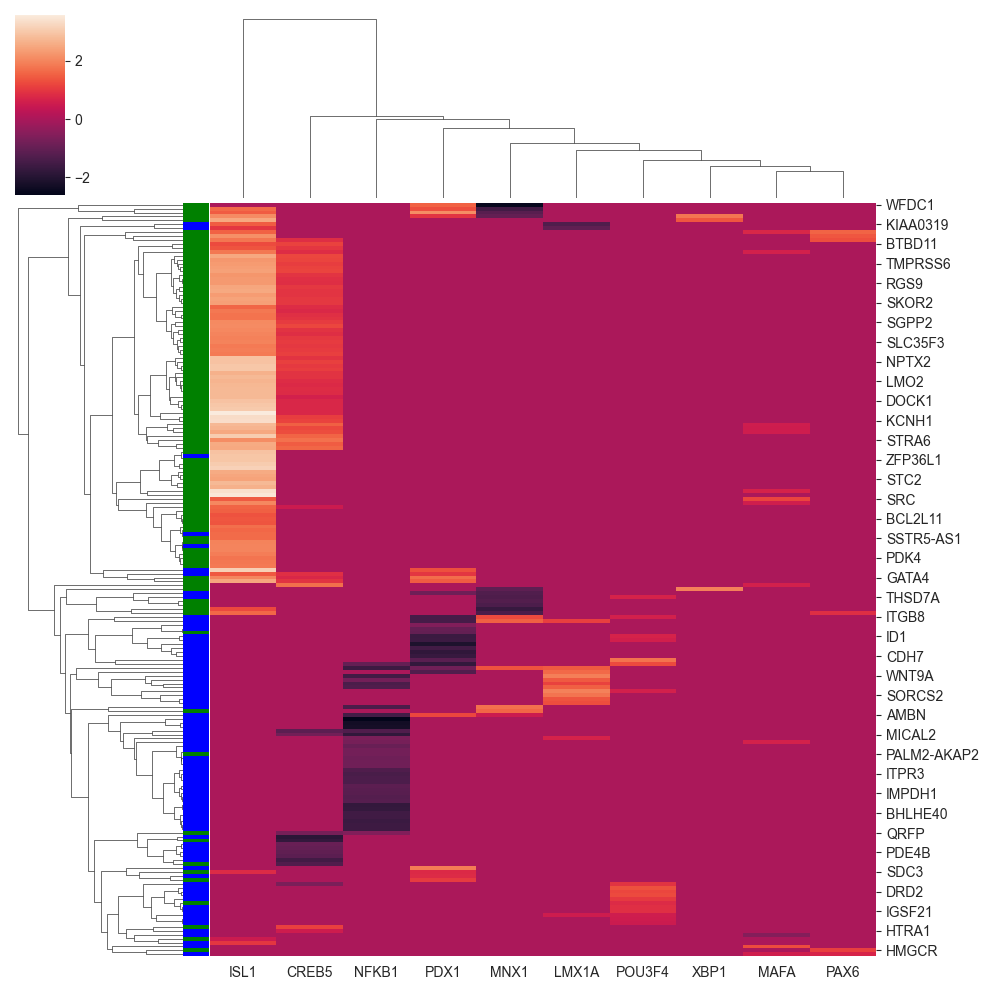

In [1193]:
df = pd.DataFrame(sub_G, index=target_genes, columns=regulatory_genes)

norm = mcolors.Normalize(vmin=row_values.min(), vmax=row_values.max())
cmap = plt.get_cmap('viridis')  

row_colors = pd.Series(row_colors, index=df.index)

sns.clustermap(df, row_colors=row_colors)

plt.show()
